# Hotel Booking Cancellation Prediction
## Preprocessing and Training Data Development

### **Imports**

In [120]:
# importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 6)

import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy import stats
import pickle
import datetime
from sklearn import __version__ as sklearn_version

### **Loading Data**

In [53]:
# mounting the drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# loading the cleaned dataset
working_dir = "/content/drive/MyDrive/hotel-booking-cancellation-prediction/data/"
hotels = pd.read_csv(working_dir + "interim/hotels_cleaned.csv")

In [55]:
# function for replacing least common categorical values from given feature if those values are less then threshold
def least_categ_replace(feature, thresh):
    feature_counts = hotels[feature].value_counts()
    mask = hotels[feature].isin(feature_counts[feature_counts < thresh].index)
    hotels.loc[mask, feature] = 'Other'
    print(hotels[feature].value_counts())

In [56]:
hotels.describe(exclude='O').T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119389.0,0.370411,0.482917,0.00,0.00,0.00,1.0,1.0
lead_time,119389.0,104.011994,106.863358,0.00,18.00,69.00,160.0,737.0
arrival_date_year,119389.0,2016.156555,0.707479,2015.00,2016.00,2016.00,2017.0,2017.0
arrival_date_week_number,119389.0,27.165292,13.605134,1.00,16.00,28.00,38.0,53.0
arrival_date_day_of_month,119389.0,15.798164,8.780826,1.00,8.00,16.00,23.0,31.0
stays_in_weekend_nights,119389.0,0.927606,0.998614,0.00,0.00,1.00,2.0,19.0
stays_in_week_nights,119389.0,2.500314,1.908289,0.00,1.00,2.00,3.0,50.0
adults,119389.0,1.856402,0.579263,0.00,2.00,2.00,2.0,55.0
children,119389.0,0.103887,0.398557,0.00,0.00,0.00,0.0,10.0
babies,119389.0,0.007949,0.097437,0.00,0.00,0.00,0.0,10.0


In [57]:
hotels.describe(include='O').T

,count,unique,top,freq
hotel,119389,2,City Hotel,79329
arrival_date_month,119389,12,August,13877
meal,119389,5,BB,92309
country,119389,178,PRT,48589
market_segment,119389,8,Online TA,56477
distribution_channel,119389,5,TA/TO,97869
reserved_room_type,119389,10,A,85993
assigned_room_type,119389,12,A,74052
deposit_type,119389,3,No Deposit,104641
agent,119389,9,Other,36636


In [58]:
# checking correlation with is_canceled
hotels.corr().is_canceled.sort_values()

<ipython-input-58-e556c10bb1e1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  hotels.corr().is_canceled.sort_values()


total_of_special_requests        -0.234652
required_car_parking_spaces      -0.195496
booking_changes                  -0.144396
is_repeated_guest                -0.084792
previous_bookings_not_canceled   -0.057357
babies                           -0.032490
arrival_date_day_of_month        -0.006142
stays_in_weekend_nights          -0.001781
children                          0.005039
arrival_date_week_number          0.008160
arrival_date_year                 0.016662
stays_in_week_nights              0.024773
adr                               0.048708
days_in_waiting_list              0.054188
adults                            0.060015
previous_cancellations            0.110135
lead_time                         0.293133
is_canceled                       1.000000
Name: is_canceled, dtype: float64

- Features like total_of_special_requests, required_car_parking_spaces, and booking_changes show pre-arrival customer behavior, as data was extracted a day before guest arrivals. The correlation with the target likely arises from guests who keep their bookings tending to make more special requests and require more parking spaces prior to arrival compared to those who cancel.

In [59]:
hotels.reservation_status.unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

<Axes: title={'center': 'Reservation status'}, xlabel='reservation_status', ylabel='count'>

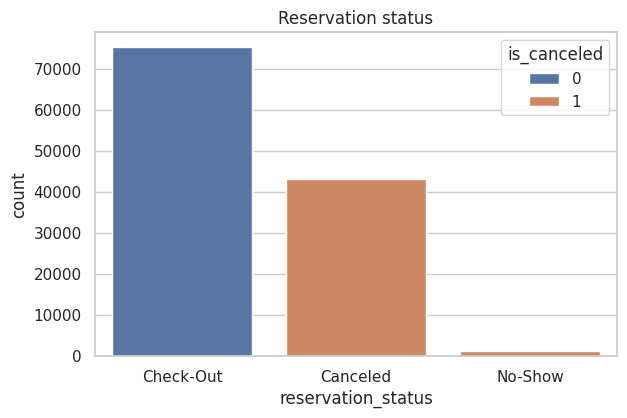

In [60]:
fig, ax = plt.subplots(figsize= (6, 4))
ax.set_title('Reservation status')
sns.countplot(x = 'reservation_status', hue = 'is_canceled', data = hotels, ax = ax)

- reservation_status is dependent of our target feature, and we can say same about reservation_status_date because the timestamp is taken either on cancelation day(prior to arrival) or on the check-out day(after arrival).

In [61]:
# dropping 2 features directly correlated(derived) from target feature
hotels.drop(axis = 1, columns = ['reservation_status', 'reservation_status_date'], inplace = True)
hotels.shape

(119389, 30)

- 'nationality' (178 countries) has high cardinality, so reducing its categories to handle potential data leakage.

In [62]:
least_categ_replace('country', 3000)

PRT      48589
Other    25260
GBR      12129
FRA      10415
ESP       8568
DEU       7287
ITA       3766
IRL       3375
Name: country, dtype: int64


Text(0.5, 1.0, 'Cancelation by country origin')

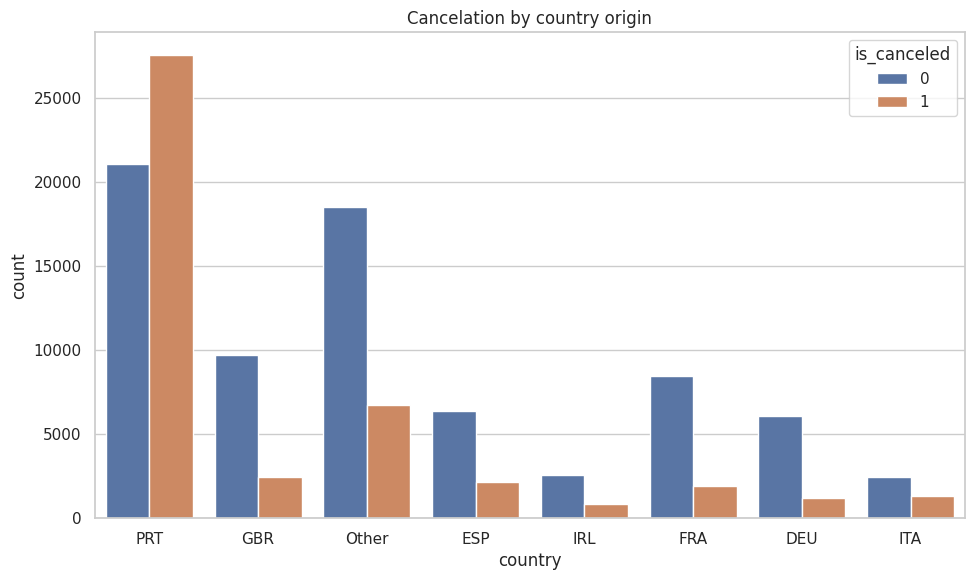

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x = 'country', hue = 'is_canceled', data = hotels, ax = ax)
plt.title('Cancelation by country origin')

- 'nationality' skewed as failed bookings marked as domestic until arrival, resulting in an uneven distribution of canceled bookings from home country which is innaccurate and misleading for the model.

In [64]:
# dropping country column to avoid data leakage
hotels.drop('country', axis=1, inplace = True)

### **Feature engineering**
Creating a few other features that might add value to dataset

arrival_day_of_week feature

In [65]:
hotels['projected_arrival'] = pd.to_datetime(hotels['arrival_date_year'].astype(str)+'-'\
                                               +hotels['arrival_date_month'].astype(str)+'-'\
                                               +hotels['arrival_date_day_of_month'].astype(str))

In [66]:
hotels['arrival_day_of_week'] = hotels['projected_arrival'].dt.dayofweek

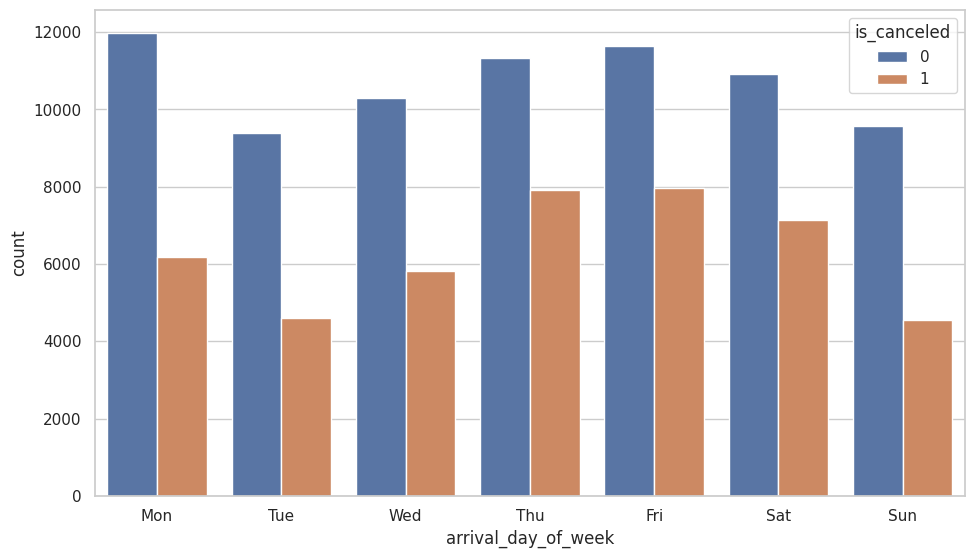

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x = 'arrival_day_of_week', hue = 'is_canceled', data = hotels, ax = ax)

ticks = list(range(0,7))
labels = "Mon Tue Wed Thu Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.show()

In [68]:
# converting arrival_date_month to integer
hotels['arrival_date_month'] = hotels['projected_arrival'].dt.month

In [69]:
hotels.drop('projected_arrival', axis=1, inplace = True)

booking_purpose feature
- short_stay - under a day - stays with 0 week nights and 0 weekend night
- business - for a few week days - stays containing 1-5 week nights and 0 weekend night
- leisure - for weekend and maybe 1 extra day - stays containing 0-1 week nights and 1-2 weekend night
- vacation - up to 3 whole weeks - stays containing 2-15 week nights and 1-7 weekend night
- long_stay - more than 3 weeks - stays containing 16+ week nights or 8+ weekend night

In [70]:
short_stay = (hotels.stays_in_week_nights == 0) & (hotels.stays_in_weekend_nights == 0)
hotels.loc[short_stay, 'booking_purpose'] = 'short_stay'

business = (hotels.stays_in_week_nights.between(1, 5)) & (hotels.stays_in_weekend_nights == 0)
hotels.loc[business, 'booking_purpose'] = 'business'

leisure = (hotels.stays_in_week_nights.between(0, 1) & (hotels.stays_in_weekend_nights.between(1,2)))
hotels.loc[leisure, 'booking_purpose'] = 'leisure'

vacation = (hotels.stays_in_week_nights.between(2, 15)) & (hotels.stays_in_weekend_nights.between(1,7))
hotels.loc[vacation, 'booking_purpose'] = 'vacation'

long_stay = (hotels.stays_in_week_nights >= 16) | (hotels.stays_in_weekend_nights >= 8)
hotels.loc[long_stay, 'booking_purpose'] = 'long_stay'

hotels.booking_purpose.value_counts()

business      51282
vacation      46446
leisure       20789
short_stay      715
long_stay       157
Name: booking_purpose, dtype: int64

In [71]:
hotels.booking_purpose.isnull().sum()

0

<Axes: xlabel='stays_in_week_nights', ylabel='stays_in_weekend_nights'>

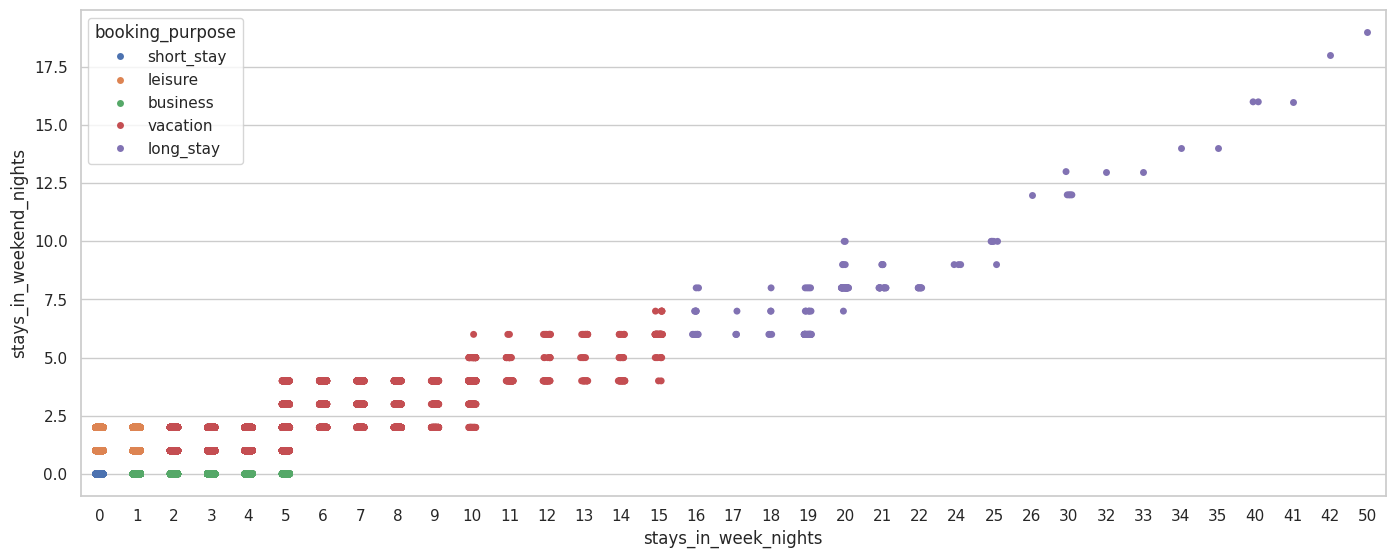

In [72]:
sns.stripplot( data=hotels, x="stays_in_week_nights", y="stays_in_weekend_nights", hue="booking_purpose")

<Axes: xlabel='booking_purpose', ylabel='count'>

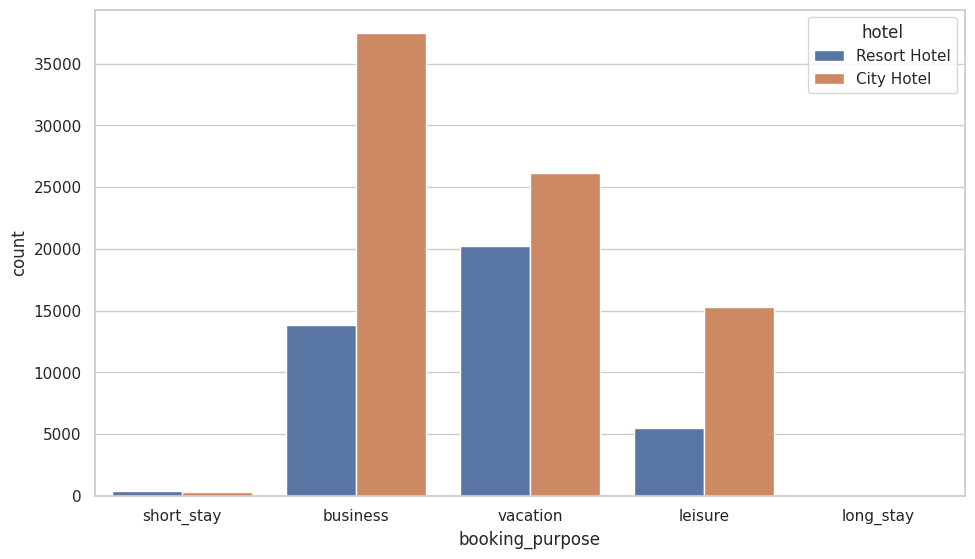

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x = 'booking_purpose', hue = 'hotel', data = hotels, ax = ax)

- Majority of customers went to Resort Hotel for vacation, while most of City Hotel customers were there with business.

received_different_room feature

In [74]:
# difference between what customers reserved and what they were assigned
hotels.reserved_room_type.value_counts() - hotels.assigned_room_type.value_counts()

A                   11941.0
B                   -1045.0
C                   -1443.0
D                   -6121.0
E                   -1271.0
F                    -854.0
G                    -459.0
H                    -111.0
I                       NaN
K                       NaN
L                       5.0
P                       0.0
dtype: float64

In [75]:
print('{}% bookings received a different room from what they reserved'.\
      format(round((hotels.assigned_room_type != hotels.reserved_room_type).mean()*100, 2)))

12.49% bookings received a different room from what they reserved


In [76]:
hotels[(hotels.assigned_room_type != hotels.reserved_room_type)][['assigned_room_type','reserved_room_type']].value_counts()

assigned_room_type  reserved_room_type
D                   A                     7548
C                   A                     1447
E                   A                     1156
B                   A                     1123
E                   D                      686
                                          ... 
F                   L                        1
B                   L                        1
D                   H                        1
H                   L                        1
C                   L                        1
Length: 65, dtype: int64

- Many times unavailable booked room was D, C, E or B and they received A instead.

In [77]:
# price difference
hotels.groupby('assigned_room_type').mean().adr

<ipython-input-77-7c2d2fdd3e1d>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hotels.groupby('assigned_room_type').mean().adr


assigned_room_type
A                    93.070683
B                    94.450264
C                   113.423583
D                   107.453633
E                   117.704224
F                   151.889931
G                   166.530309
H                   171.380772
I                    40.843774
K                    53.698889
L                     8.000000
P                     0.000000
Name: adr, dtype: float64

<Axes: xlabel='assigned_room_type', ylabel='adr'>

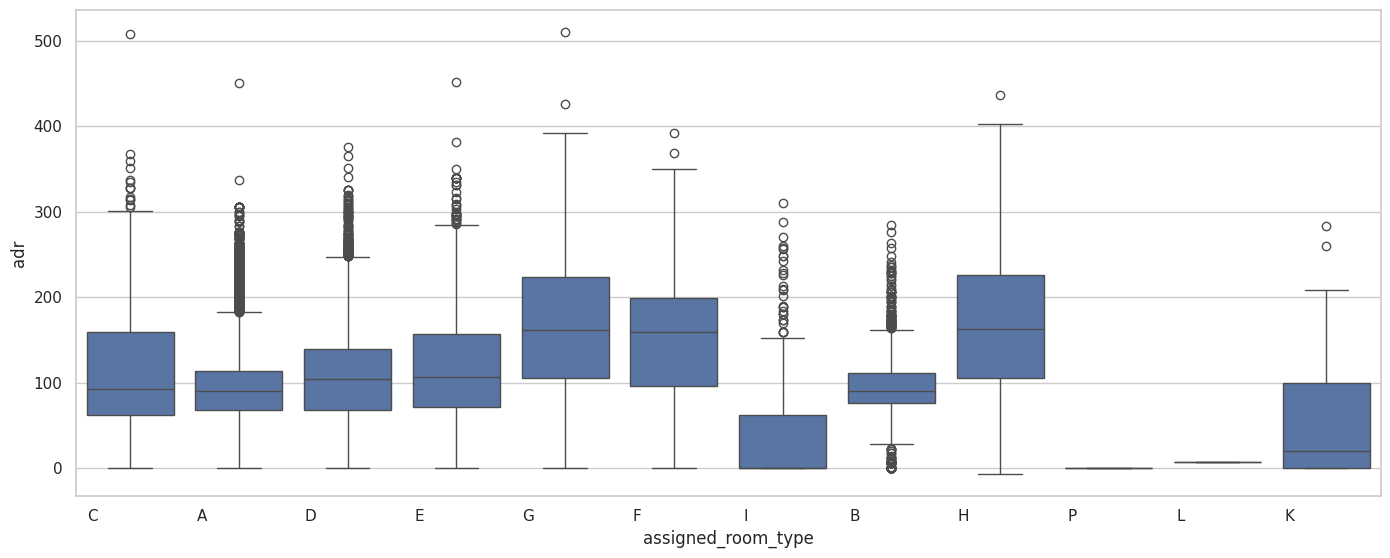

In [78]:
sns.boxplot(x = 'assigned_room_type', y = 'adr', data = hotels)

Since most bookings received the requested room type, creating a binary 'received_different_room' feature and dropping redundant 'assigned_room_type'.

In [79]:
hotels['received_different_room'] = (hotels.assigned_room_type != hotels.reserved_room_type).astype('int')

In [80]:
# reducing number of categories by keeping only room types with more than 1000 records.
least_categ_replace('reserved_room_type', 1000)

A                   85993
D                   19201
E                    6535
F                    2897
G                    2094
Other                1551
B                    1118
Name: reserved_room_type, dtype: int64


In [81]:
hotels.drop('assigned_room_type', axis=1, inplace = True)

#### Binning categorical features

In [82]:
hotels.describe(include ='O').T

,count,unique,top,freq
hotel,119389,2,City Hotel,79329
meal,119389,5,BB,92309
market_segment,119389,8,Online TA,56477
distribution_channel,119389,5,TA/TO,97869
reserved_room_type,119389,7,A,85993
deposit_type,119389,3,No Deposit,104641
agent,119389,9,Other,36636
company,119389,4,no_company,112592
customer_type,119389,4,Transient,89612
booking_purpose,119389,5,business,51282


Some categorical features have values that are uncommon replacing those below a threshold with 'Other'.

In [83]:
hotels.meal.value_counts()

BB           92309
HB           14463
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64

In [84]:
hotels.market_segment.value_counts()

Online TA        56477
Offline TA/TO    24218
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: market_segment, dtype: int64

In [85]:
hotels.distribution_channel.value_counts()

TA/TO        97869
Direct       14645
Corporate     6677
GDS            193
Undefined        5
Name: distribution_channel, dtype: int64

In [86]:
for feature in ['meal', 'market_segment', 'distribution_channel']:
    least_categ_replace(feature, 5000)
    hotels[feature].value_counts()

BB           92309
HB           14463
SC           10650
Other         1967
Name: meal, dtype: int64
Online TA        56477
Offline TA/TO    24218
Groups           19811
Direct           12606
Corporate         5295
Other              982
Name: market_segment, dtype: int64
TA/TO        97869
Direct       14645
Corporate     6677
Other          198
Name: distribution_channel, dtype: int64


### **Customer segmentation - Unsupervised learning**

In [87]:
# selecting relevant features
hotels_clustering = hotels[['is_canceled', 'hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type',
                         'agent', 'company', 'customer_type', 'booking_purpose', 'lead_time', 'arrival_date_week_number',
                         'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations',
                         'previous_bookings_not_canceled', 'booking_changes', 'adr', 'arrival_day_of_week']]

#### Encoding Categorical features

In [88]:
hotels_clustering.describe(include ='O').T

,count,unique,top,freq
hotel,119389,2,City Hotel,79329
meal,119389,4,BB,92309
market_segment,119389,6,Online TA,56477
distribution_channel,119389,4,TA/TO,97869
reserved_room_type,119389,7,A,85993
deposit_type,119389,3,No Deposit,104641
agent,119389,9,Other,36636
company,119389,4,no_company,112592
customer_type,119389,4,Transient,89612
booking_purpose,119389,5,business,51282


In [89]:
hotels_clustering_num = pd.get_dummies(hotels_clustering, drop_first=True)

In [90]:
hotels_clustering_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119389 entries, 0 to 119388
Data columns (total 50 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   is_canceled                          119389 non-null  int64  
 1   lead_time                            119389 non-null  int64  
 2   arrival_date_week_number             119389 non-null  int64  
 3   adults                               119389 non-null  int64  
 4   children                             119389 non-null  float64
 5   babies                               119389 non-null  int64  
 6   is_repeated_guest                    119389 non-null  int64  
 7   previous_cancellations               119389 non-null  int64  
 8   previous_bookings_not_canceled       119389 non-null  int64  
 9   booking_changes                      119389 non-null  int64  
 10  adr                                  119389 non-null  float64
 11  arrival_day_o

#### Train test split

In [91]:
# features
X = hotels_clustering_num.drop('is_canceled', axis=1)
# label
y = hotels_clustering_num['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

#### KMeans on raw data

In [92]:
# function for processing the KMeans model and output inertias graph
def clustering_plotting_elbow(df, n = 10):
    ks = range(1,n+1)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters = k, random_state = 123)
        model.fit(df)
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o')
    plt.xlabel('Number of Clusters, k')
    plt.ylabel('Inertia')
    plt.xticks(ks)
    plt.show()

In [116]:
# function to visualize the silhoutte scoring and clusters
def plotting_silhouette(df, n = 6):
    range_n_clusters = list(range(2,n+1))

    for n_clusters in range_n_clusters:
        fig, ax1 = plt.subplots(1,1)
        fig.set_size_inches(18, 7)
# silhouette coefficient can range from [-1, 1], taking it within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to set clear boundaries
        ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator seed of 123 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=123)
        cluster_labels = clusterer.fit_predict(df)

# silhouette_score gives the average value for all the samples
# It gives a perspective into density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
# Aggregate silhouette scores for samples belonging to cluster i and sort them
            ith_cluster_silhouette_values =  sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color,
                              edgecolor=color, alpha=0.7)

# Label silhouette plots with cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

# Compute new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

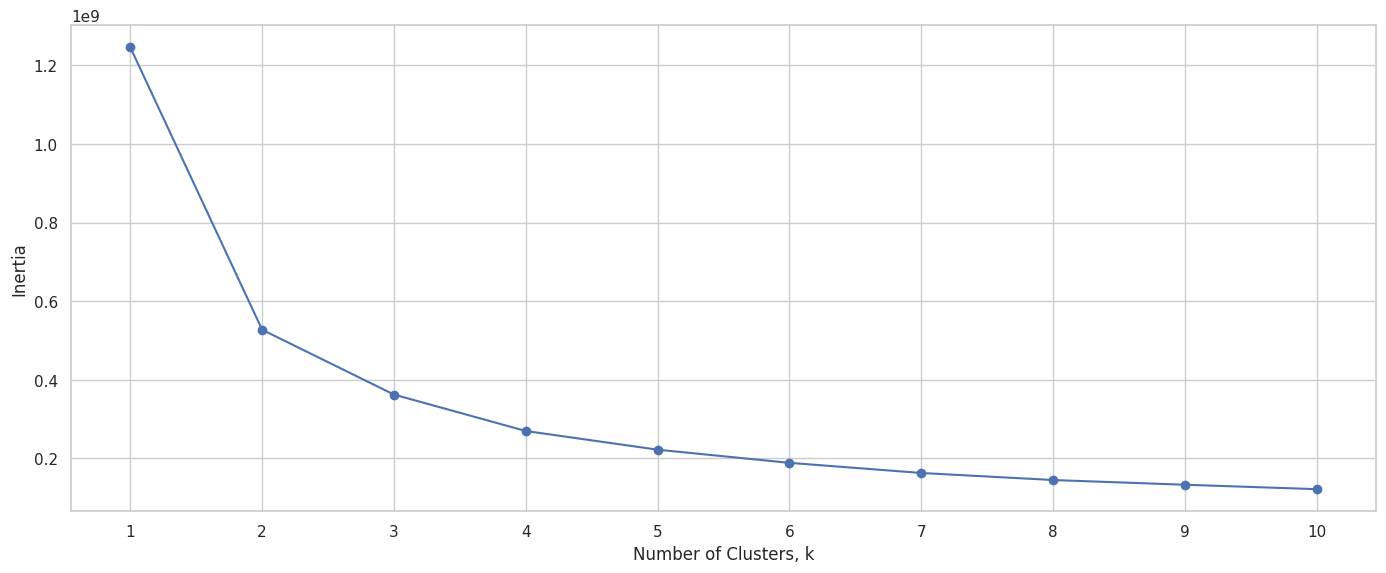

In [94]:
clustering_plotting_elbow(X_train, 10)

- using Elbow method estimating optimal number of clusters to be 2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.5353390024053064


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.4289846469004922


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.39308643339507127


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.3810436893534739


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.3569442121950956


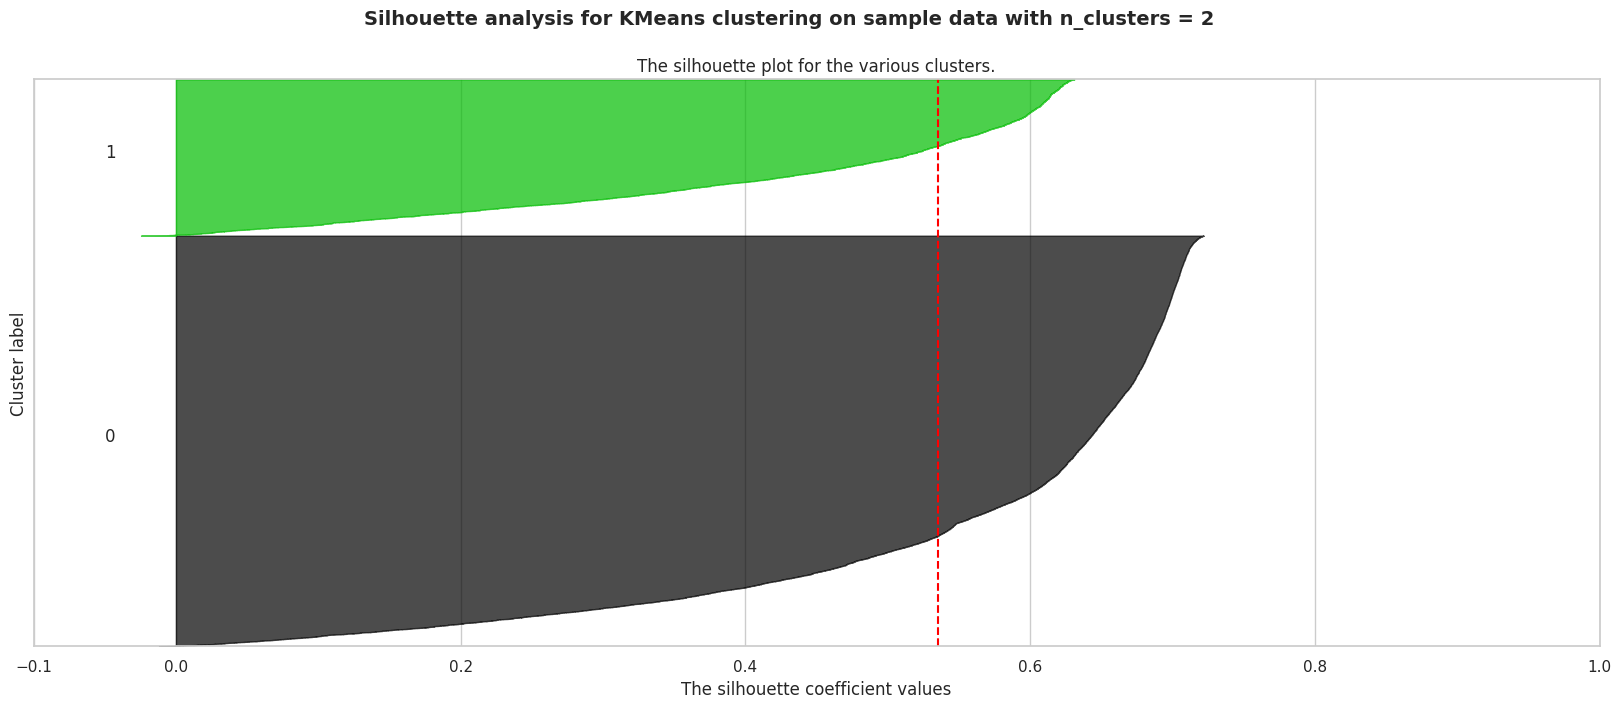

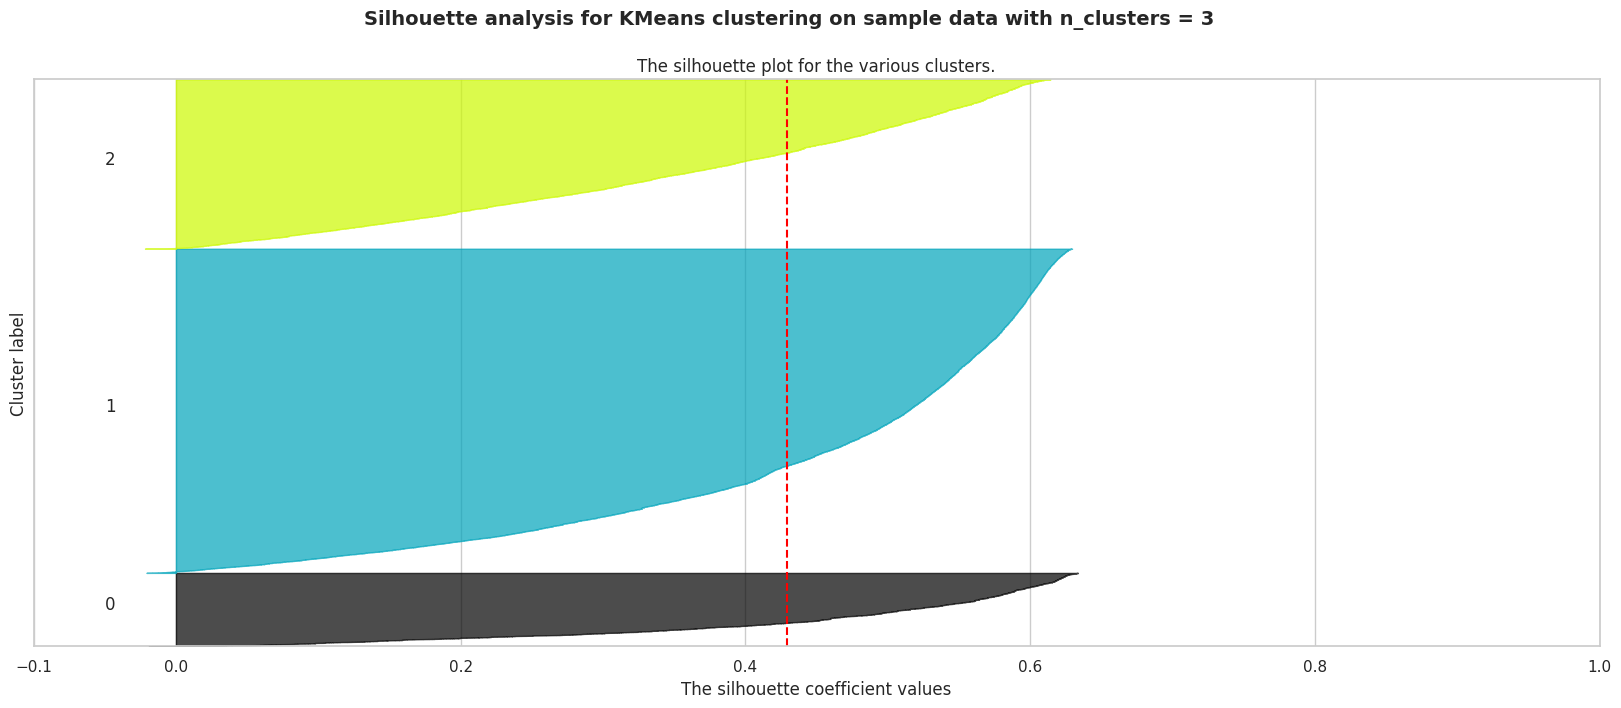

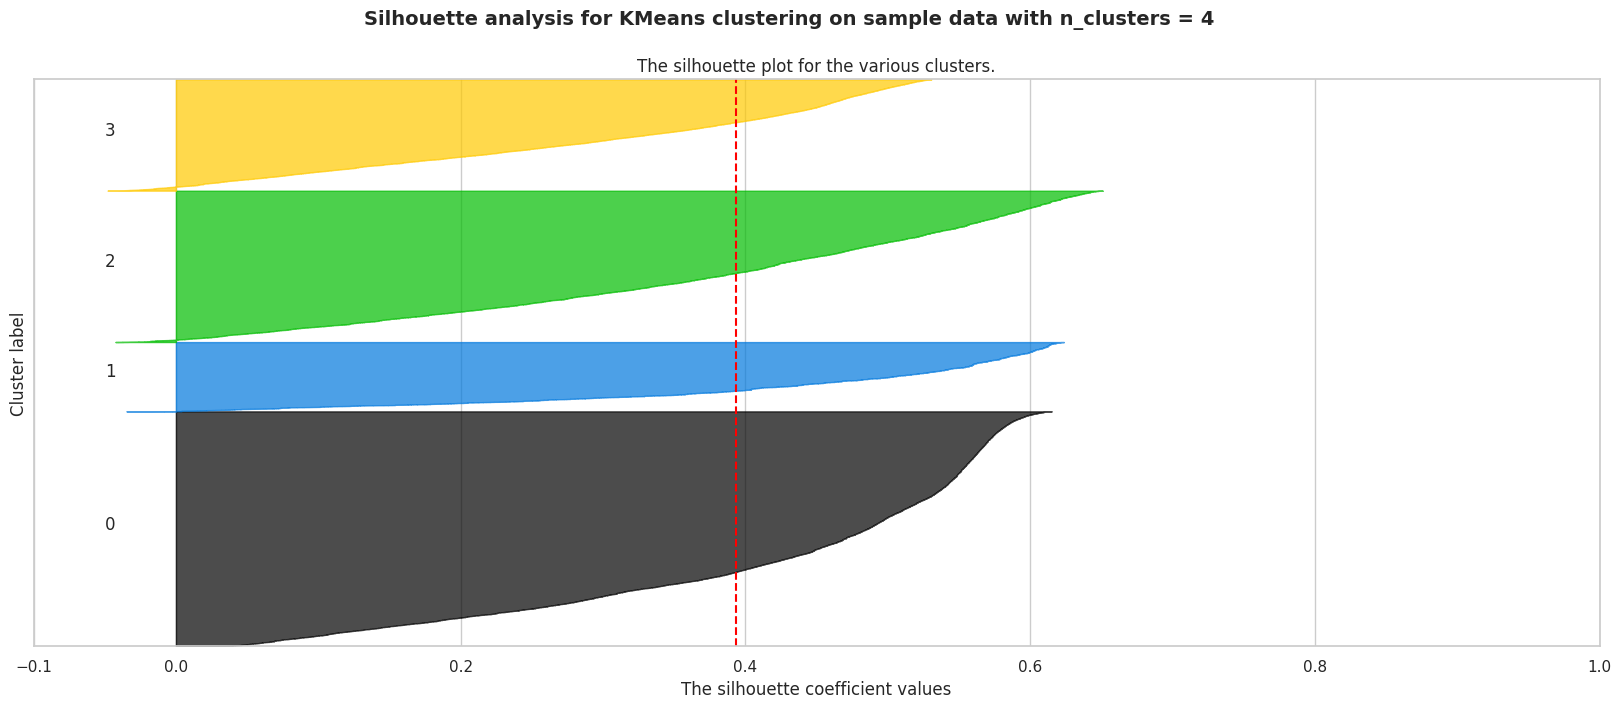

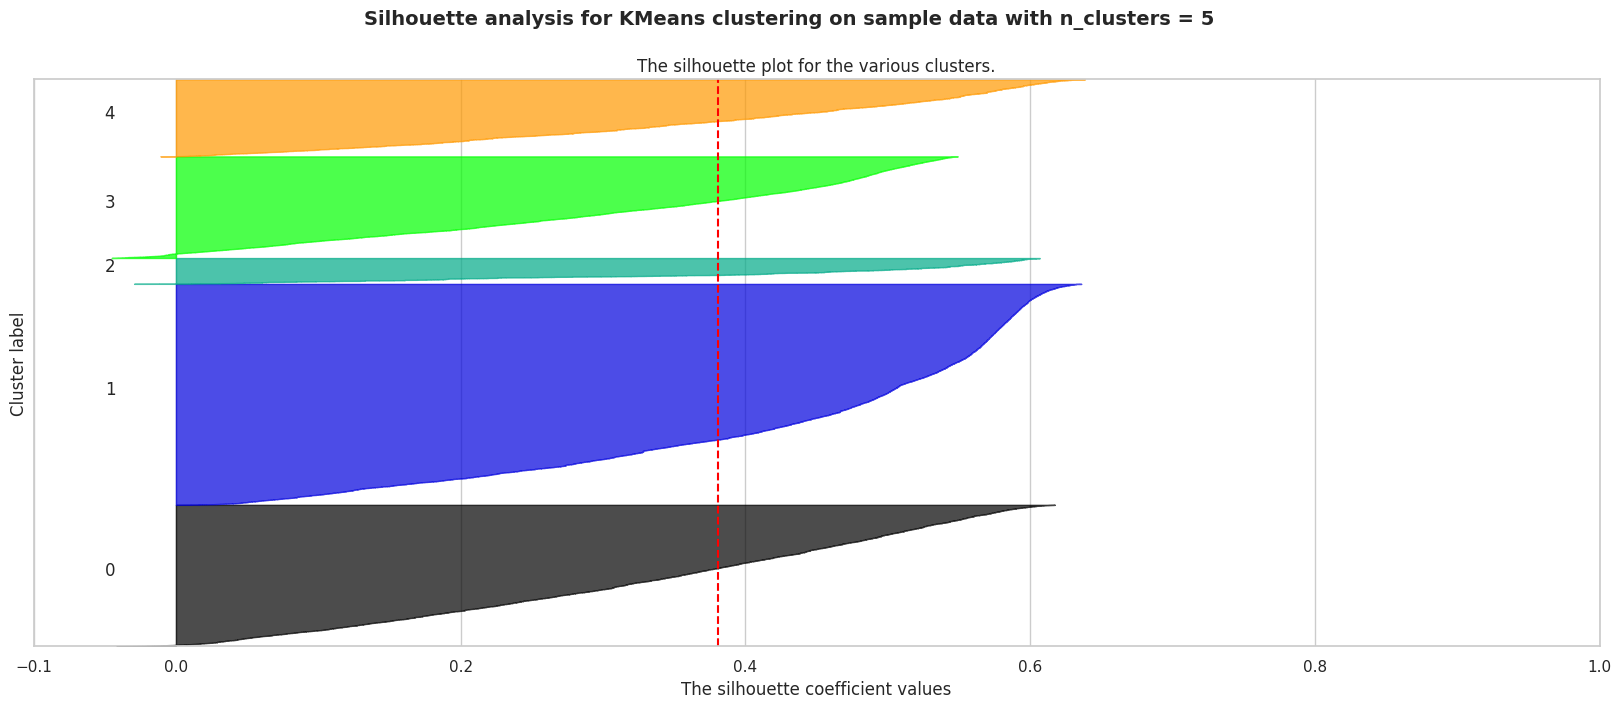

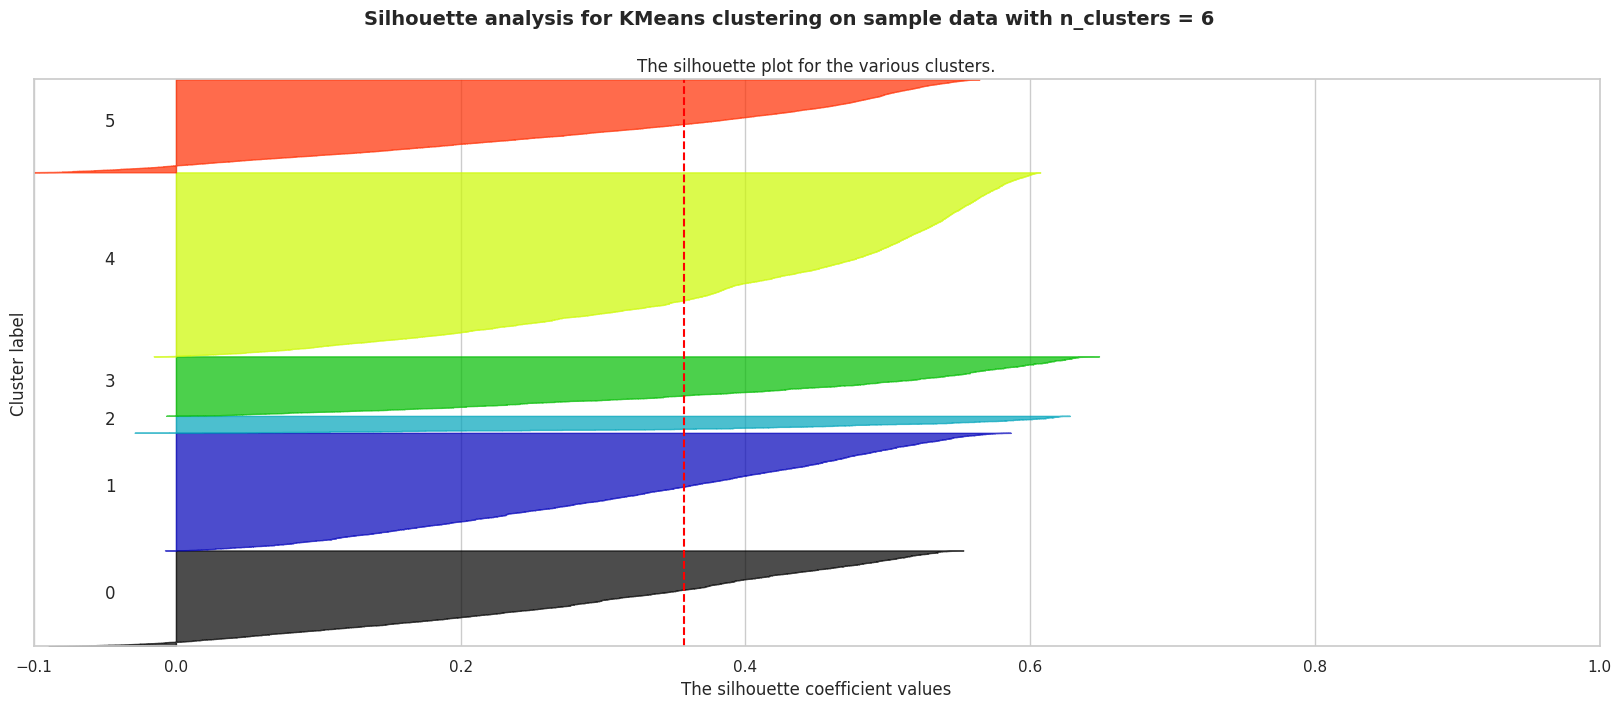

In [95]:
plotting_silhouette(X_train, 6)

- Value of n_clusters as 5 and 6 looks suboptimal for the given data because of wide fluctuations in the size of silhouette plots as we have clusters that are considerably smaller than other clusters
- Value 2, 3, 4 for n_clusters looks optimal, silhouette score for each cluster is above average. Also, fluctuation in size is similar.
- Thickness of the silhouette plot represents each cluster also is a deciding point. For plot with n_cluster 4, the thickness is more uniform than plots with n_cluster as 2 or 3 where one cluster thickness is much more than others

Thus, selecting optimal number of clusters as 4.

#### Clustering after scaling

In [96]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

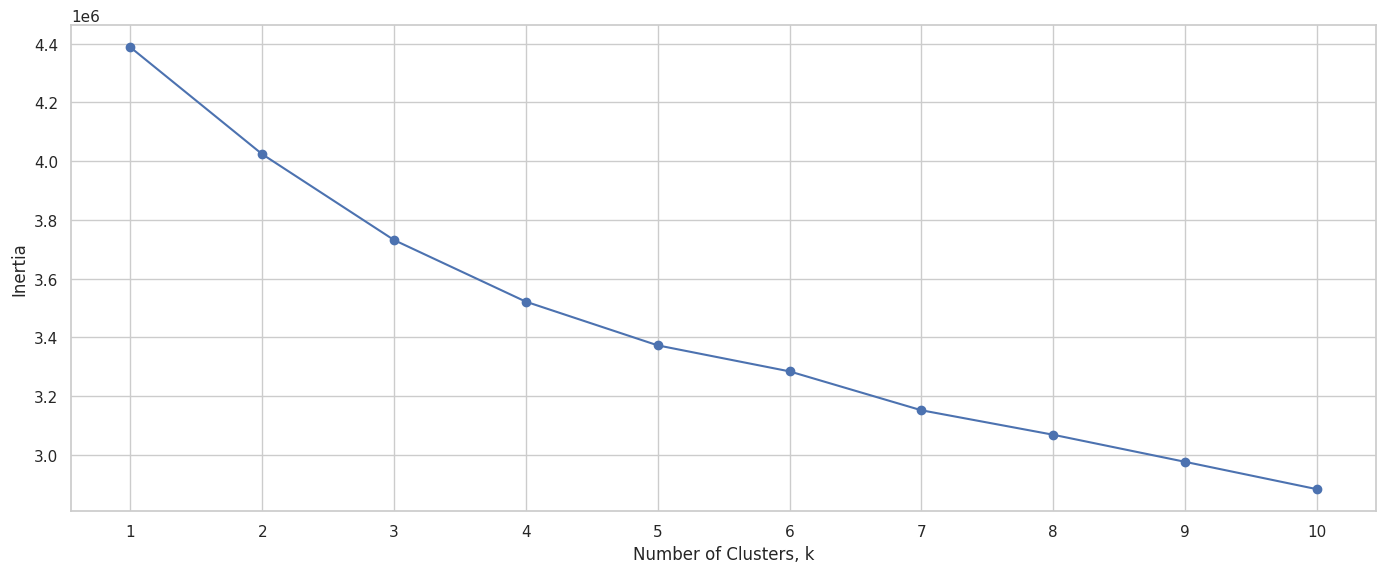

In [97]:
clustering_plotting_elbow(X_train_scaled, 10)

- using the Elbow method no obvious choices, but estimating optimal number of clusters would be 4 or 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.25695084356152403


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.112539077073955


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.1326492739833282


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.13672317318113533


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.1475248804317979


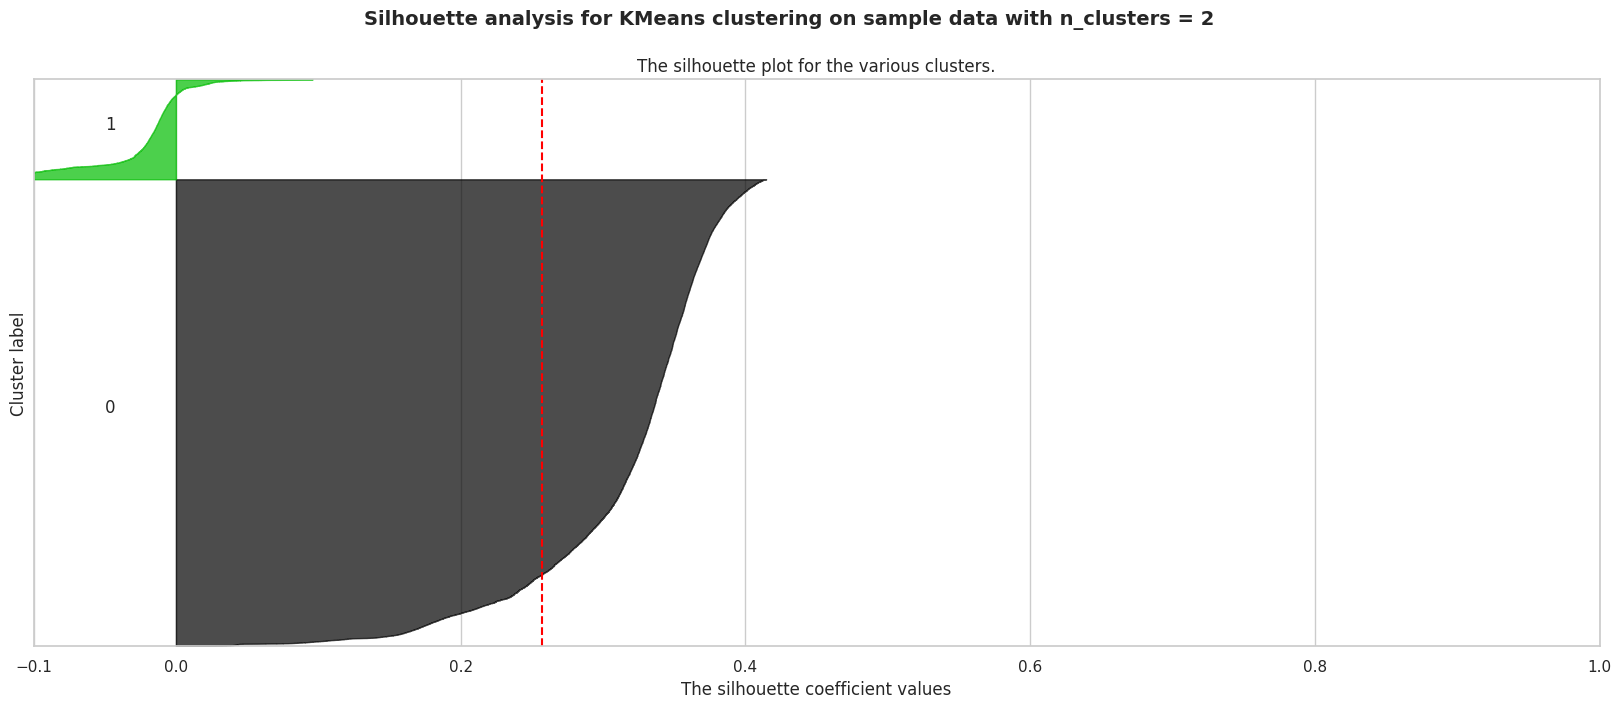

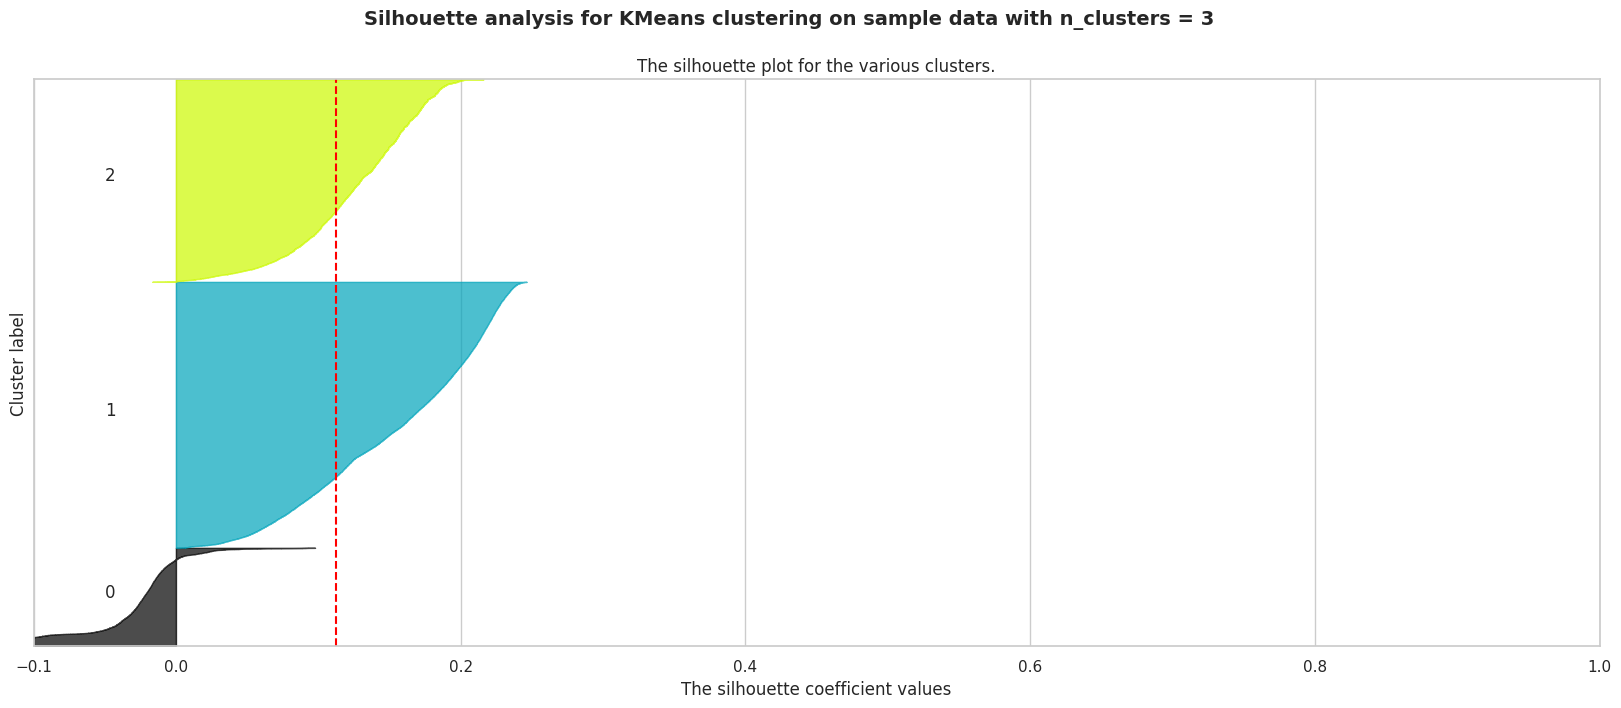

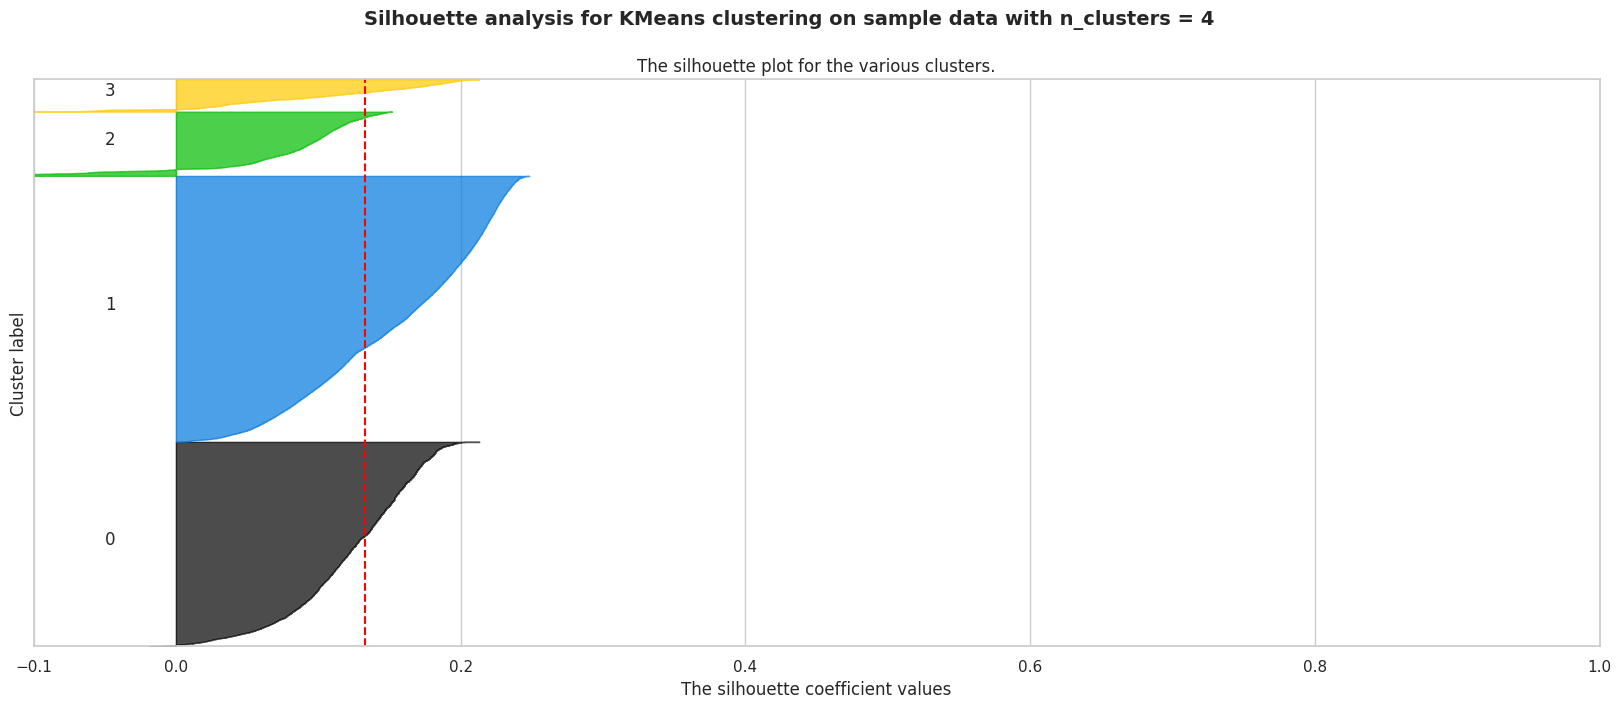

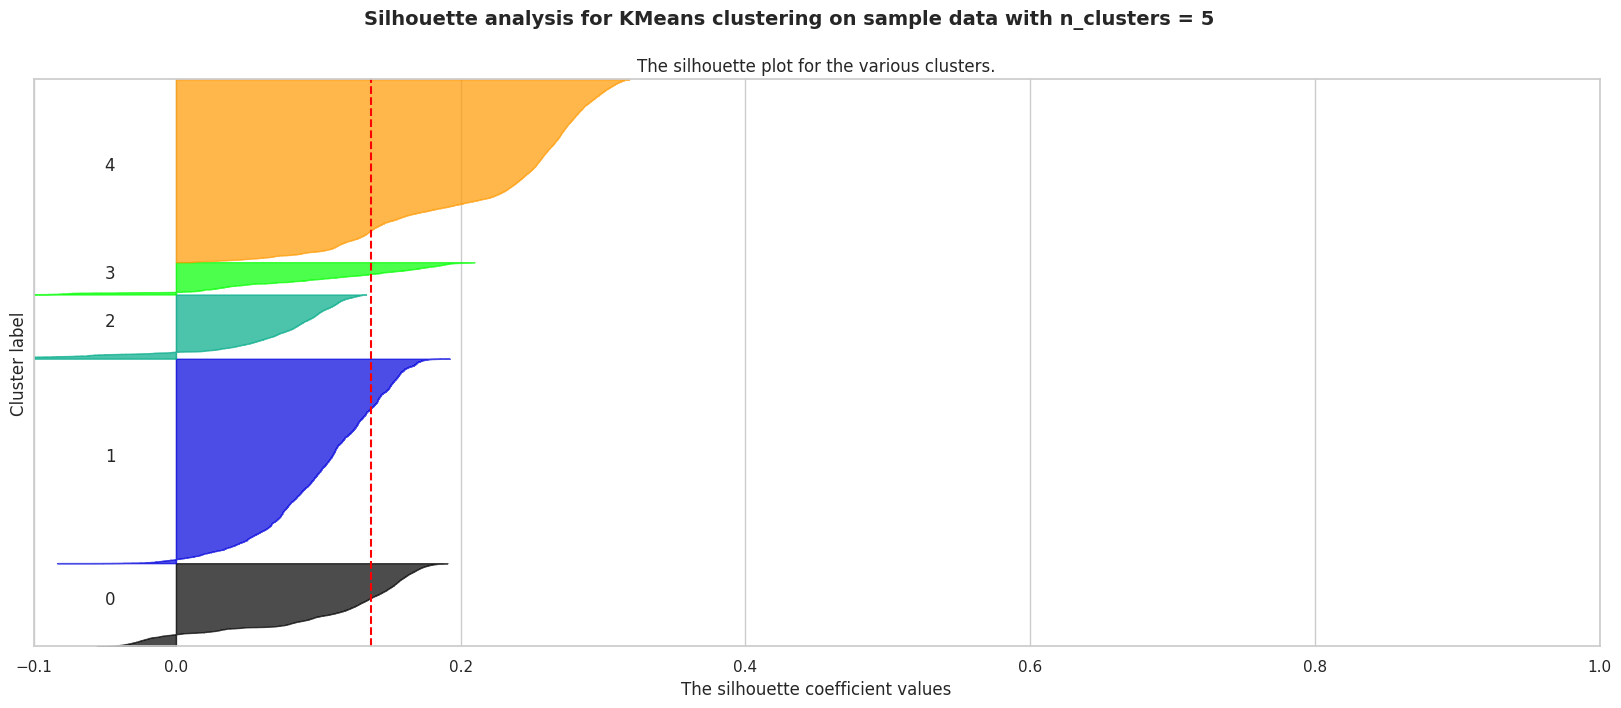

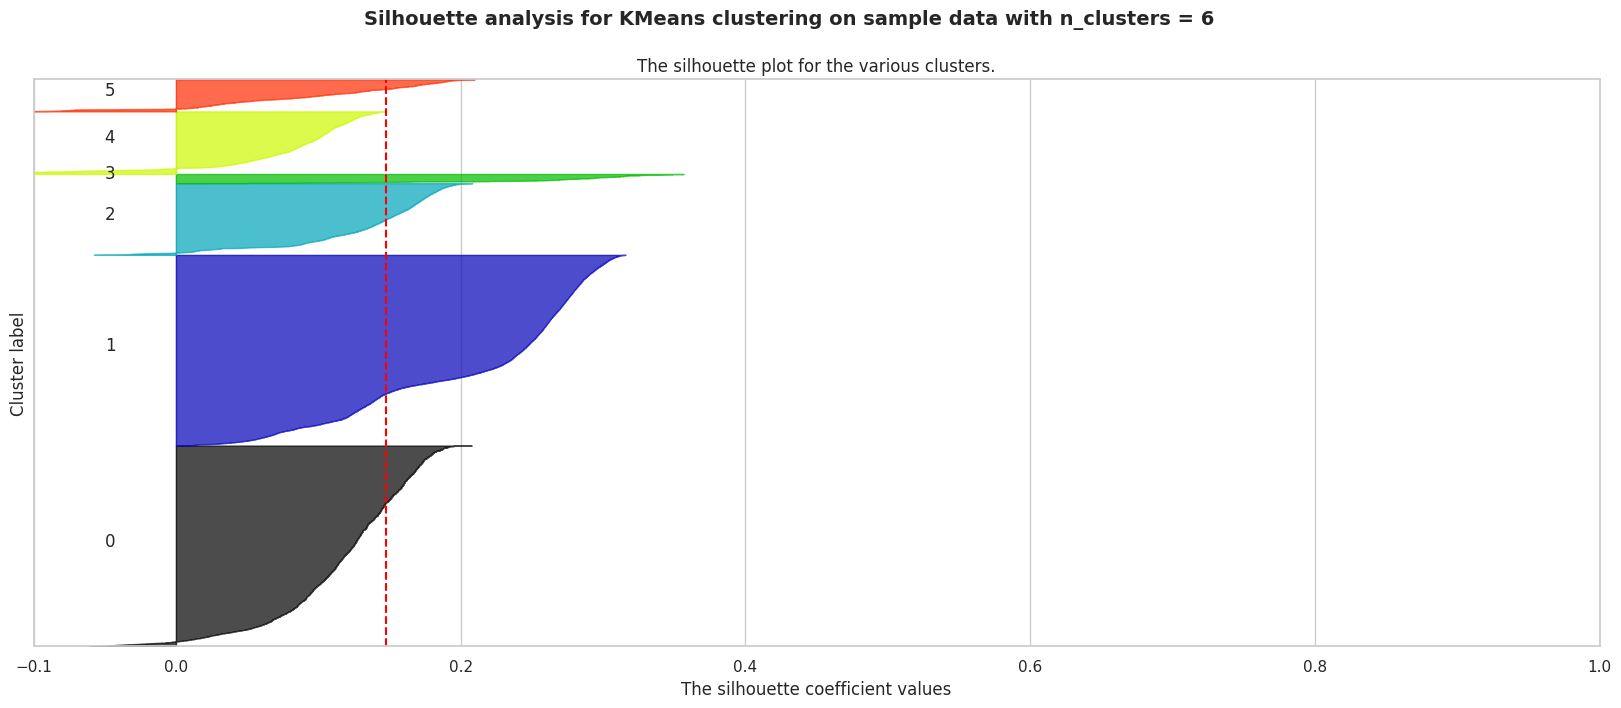

In [98]:
plotting_silhouette(X_train_scaled, 6)

- Analyzing silhouette scores, plots, clustering after using StandardScaler is worse that without, up to a point that grouping seems ambiguous
- only plots that seem to have more uniform thickness in their clusters are the clusterings around 4 and 5 clusters, but even then we see that the silhouette score is 0.13, which means that there are no underlying clusters in our data.

In [117]:
PCA_model = PCA()
# PCA is affected by scale so doing it on scaled data
PCA_model.fit(X_train_scaled)

features = range(PCA_model.n_components_)

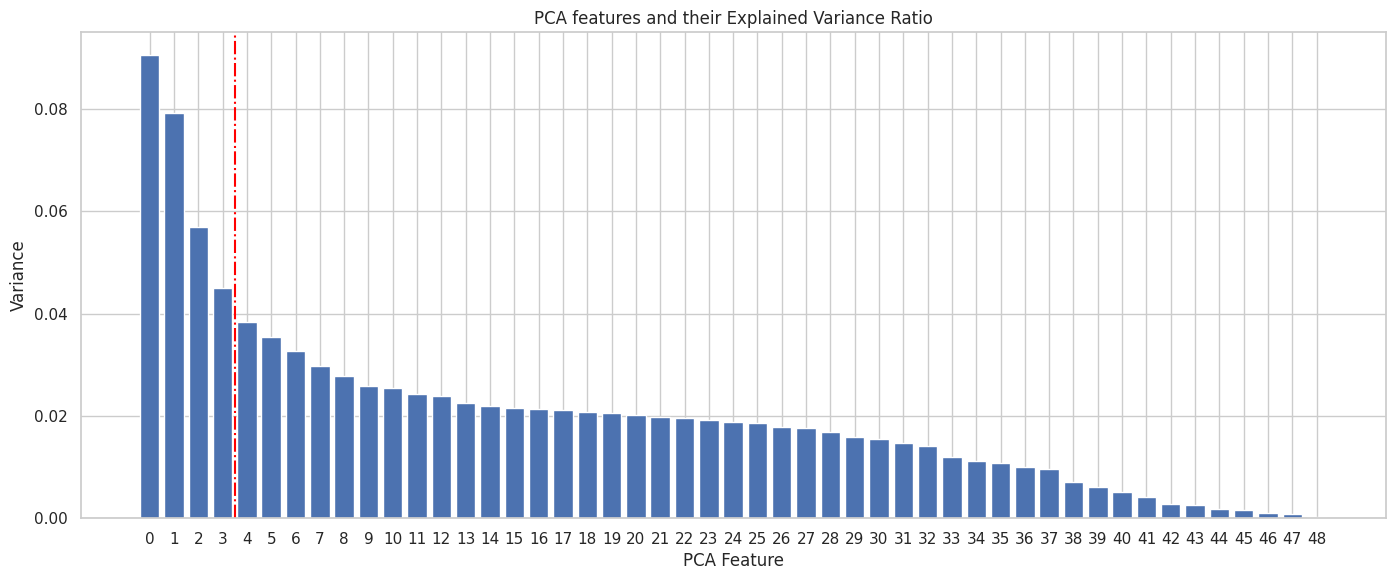

In [100]:
plt.bar(features, PCA_model.explained_variance_ratio_)
plt.axvline(3.5, c = 'red', linestyle = '-.')
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('PCA Feature')
plt.title('PCA features and their Explained Variance Ratio')
plt.show()

Text(0.5, 1.0, 'Cummulative PCA features with a 90% explained variance ratio threshold" ')

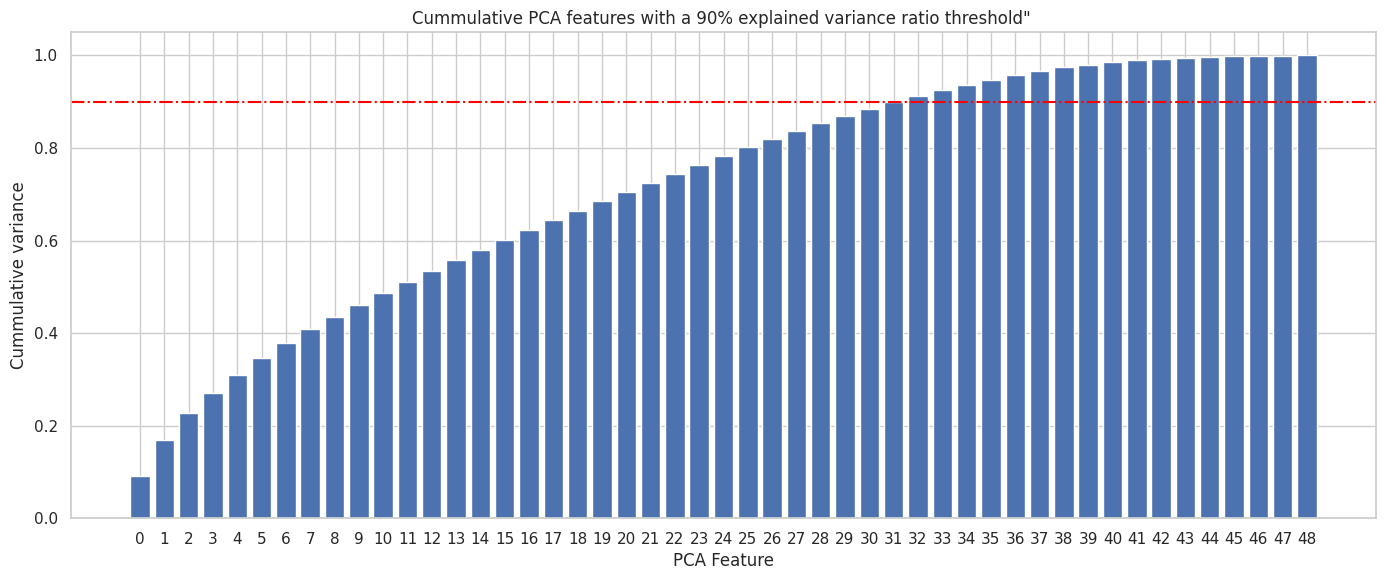

In [101]:
# cummulative plot
plt.bar(features, np.cumsum(PCA_model.explained_variance_ratio_))
plt.axhline(.9, c = 'red', linestyle = '-.', label = '')
plt.xticks(features)
plt.ylabel('Cummulative variance')
plt.xlabel('PCA Feature')
plt.title('Cummulative PCA features with a 90% explained variance ratio threshold" ')

- For our Unsupervised Clustering algorithm we will use the first 4 Principal Components

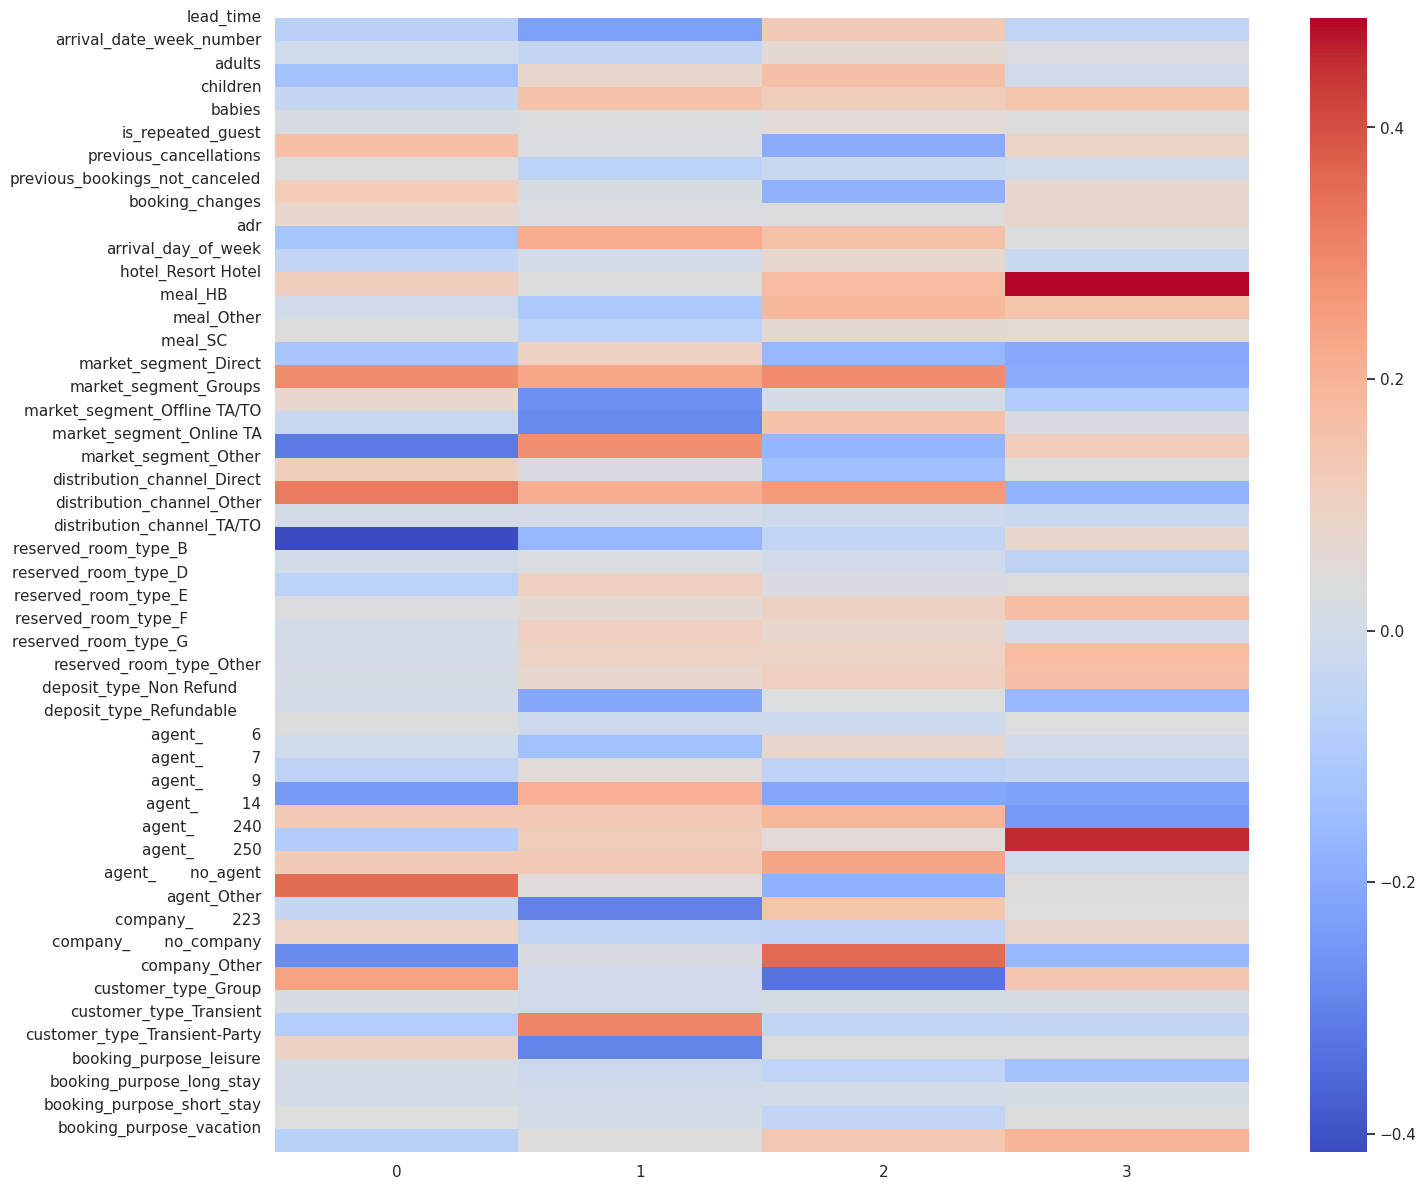

In [102]:
fig, ax = plt.subplots(1,1, figsize = (14,14))

sns.heatmap(PCA_model.components_[0:4].T, cmap = 'coolwarm')
plt.yticks(range(49), X_train.columns, rotation = 0)
plt.show()

In [103]:
X_train_pca = PCA_model.transform(X_train_scaled)
X_train_pca.shape

(89541, 49)

In [104]:
X_train_pca = X_train_pca[:,0:4]
X_train_pca.shape

(89541, 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

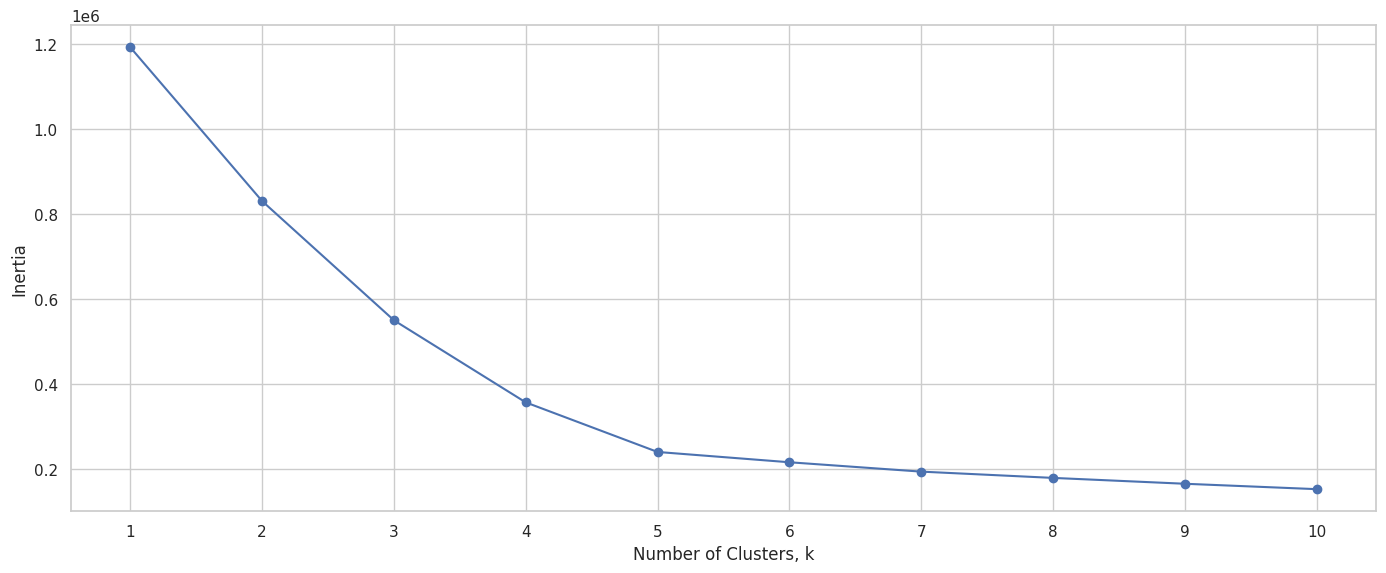

In [105]:
clustering_plotting_elbow(X_train_pca, 10)

- using Elbow method estimating the optimal number of clusters to be 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.47580620574033483


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.44452938177395934


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.4948398714332413


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.5427054317547918


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.46767601022968863


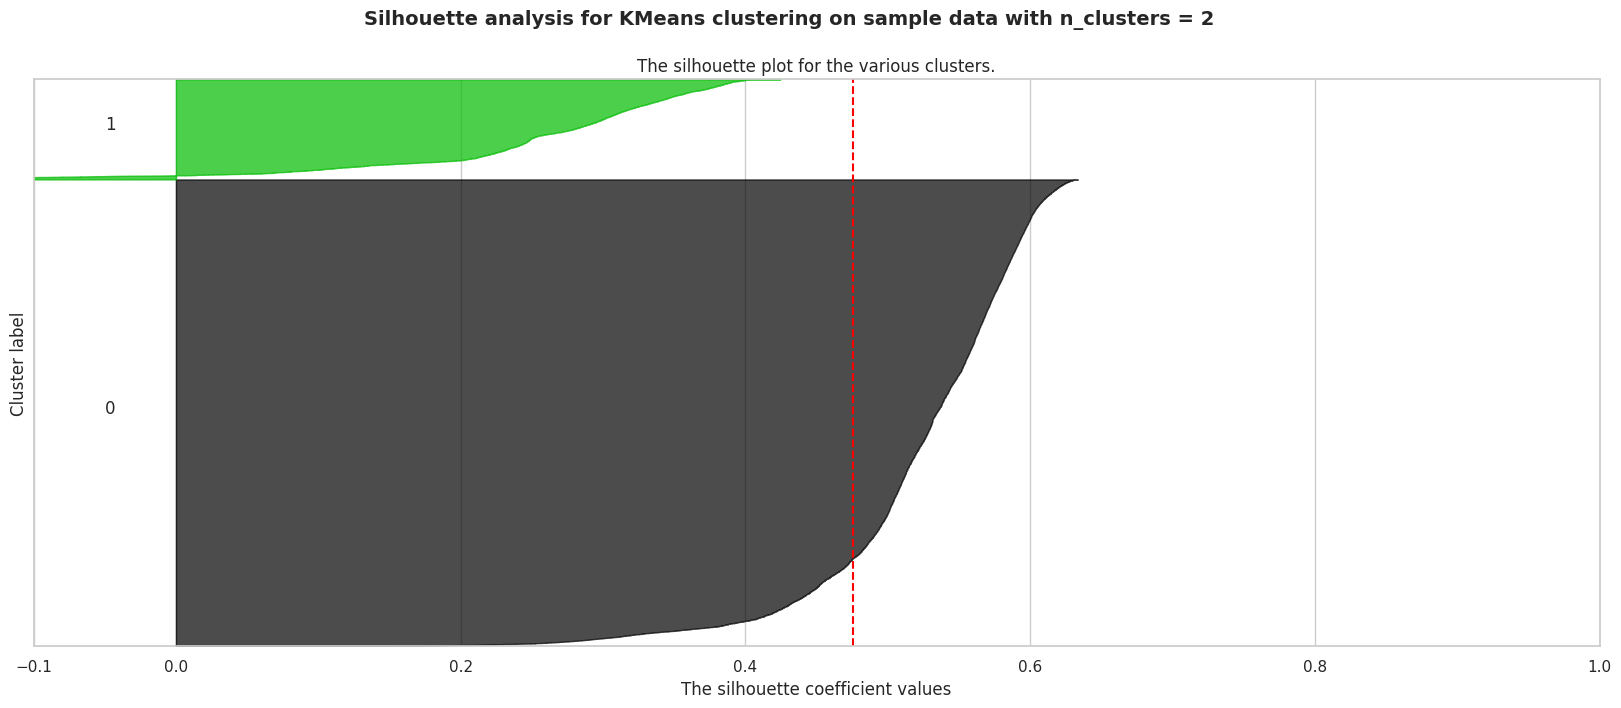

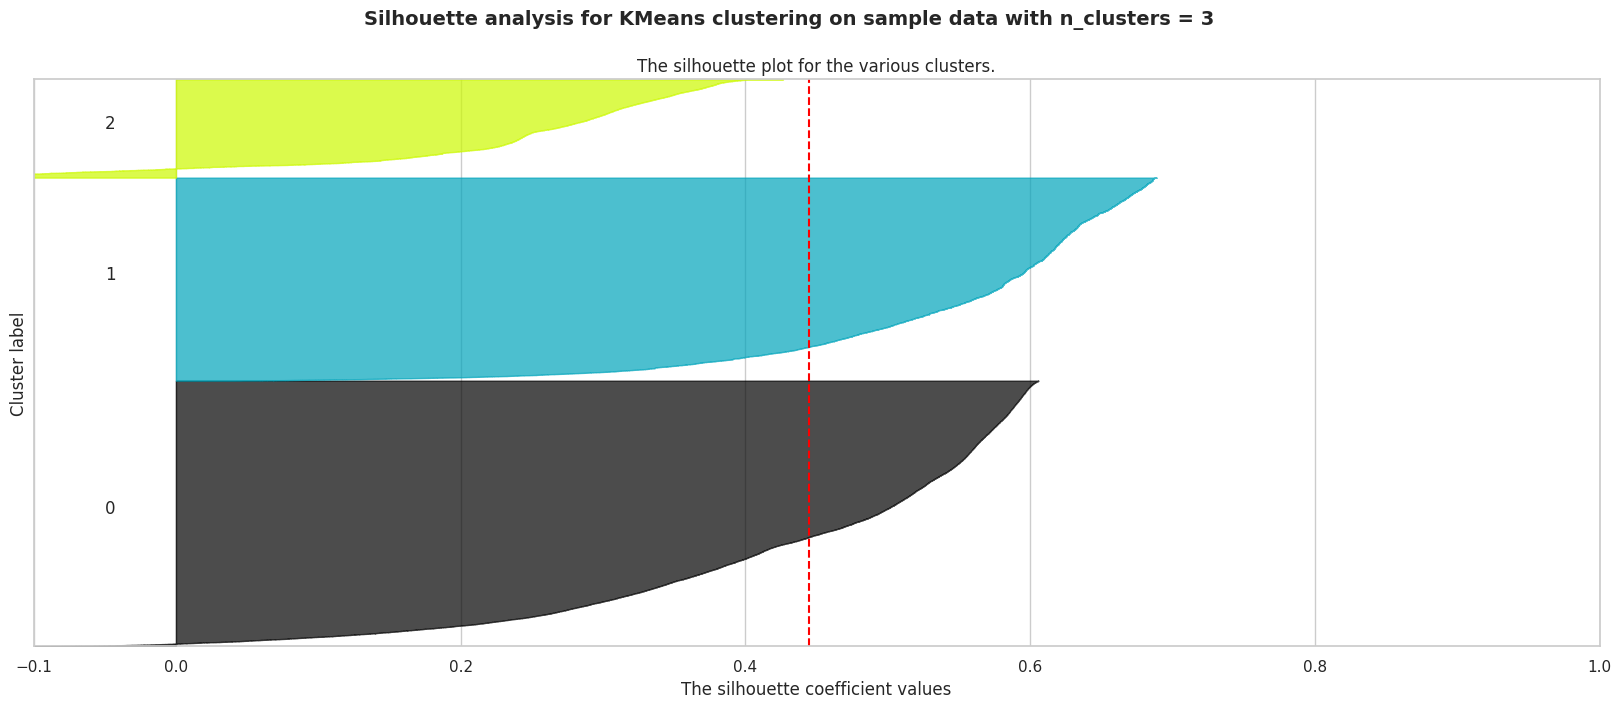

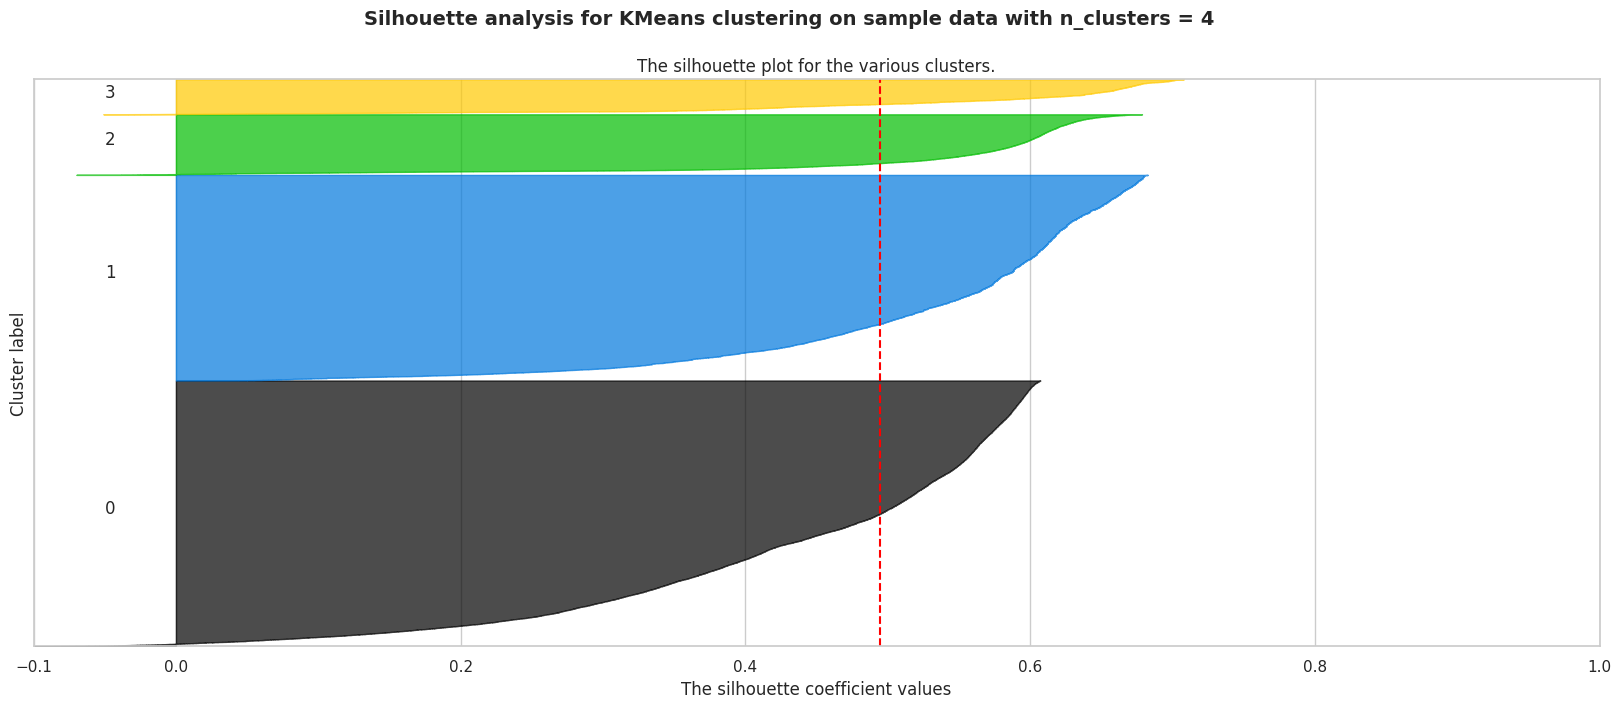

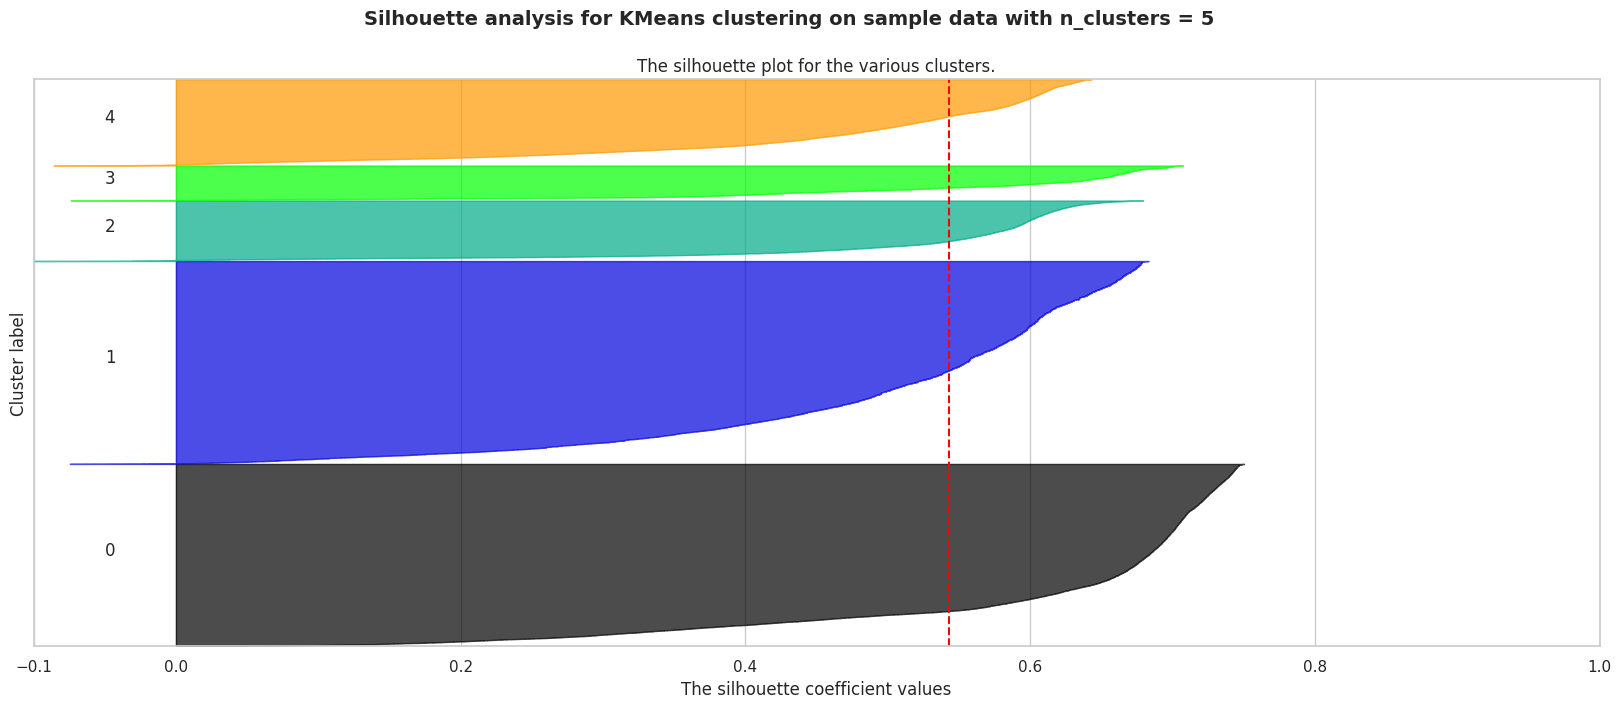

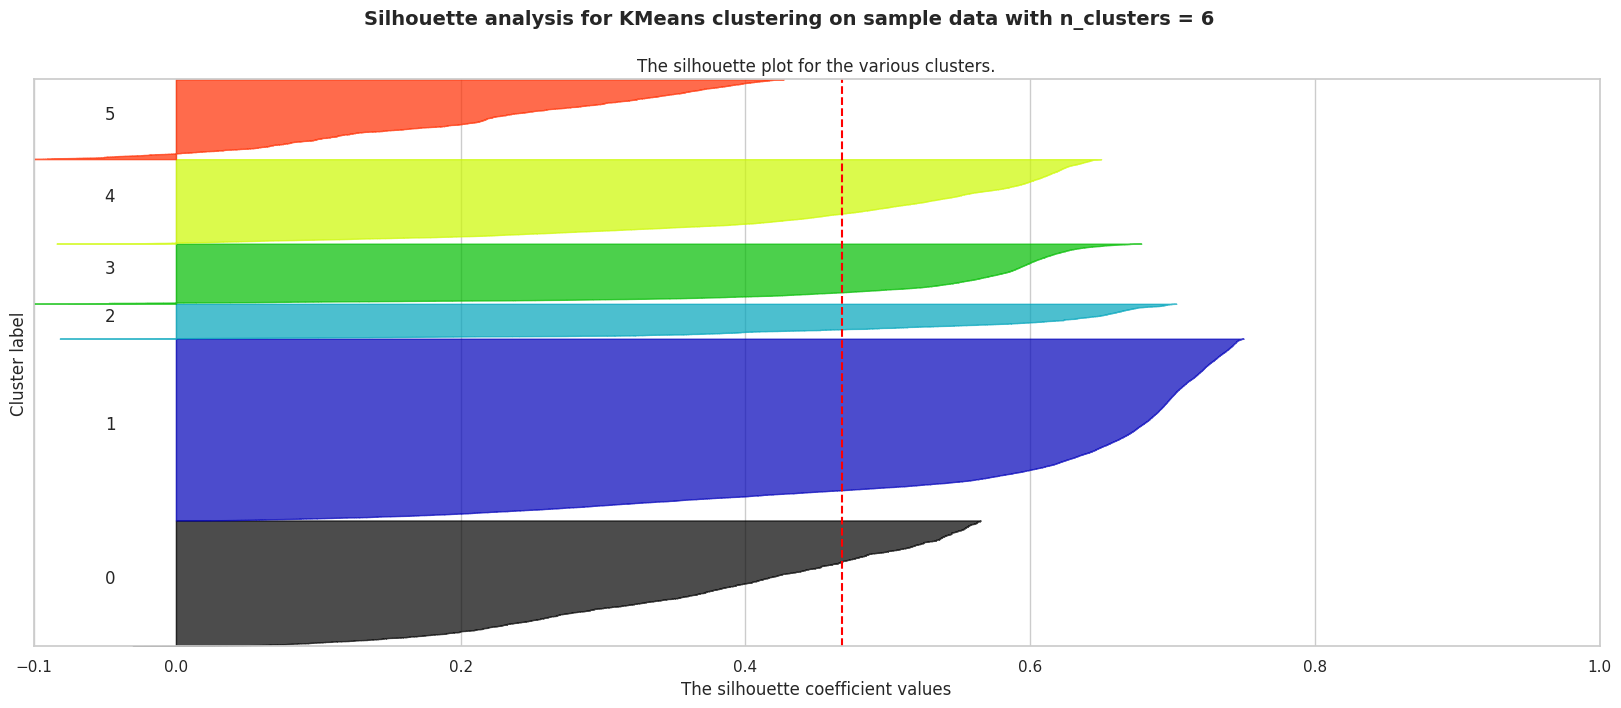

In [106]:
plotting_silhouette(X_train_pca, 6)

- Silhouette scores after PCA are overall better that scores from raw data, optimal clustering consideing plot thickness and score is the clustering with 5 clusters with a 0.54 Silhouette score.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


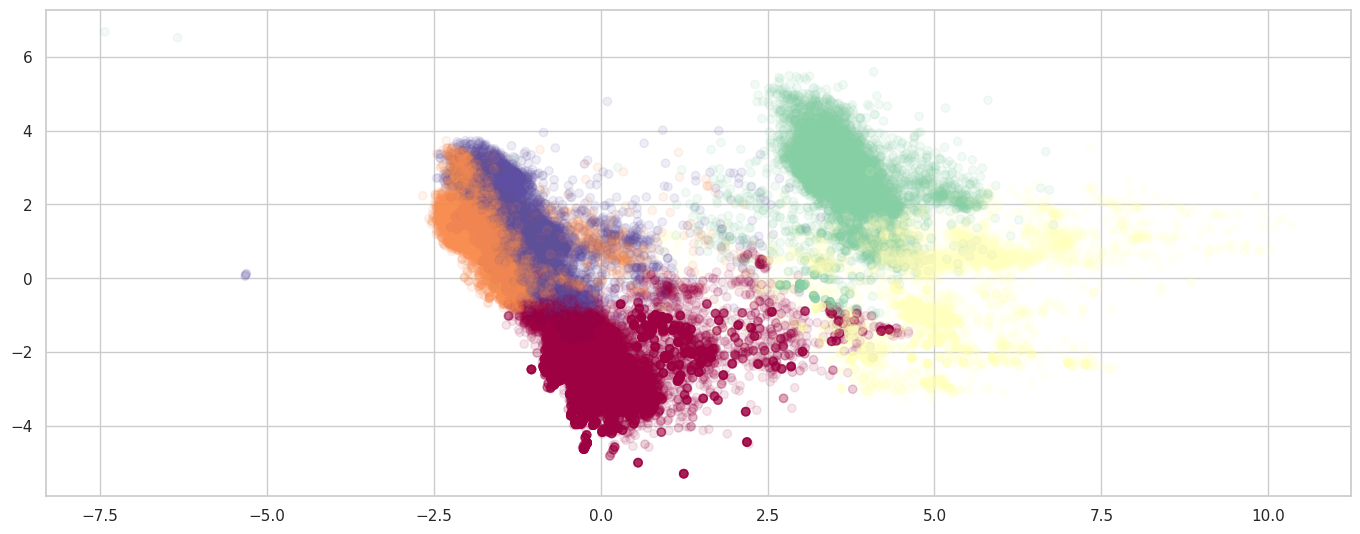

In [107]:
KMeans_model = KMeans(n_clusters = 5)
KMeans_model.fit(X_train_pca)
labels = KMeans_model.predict(X_train_pca)

plt.scatter(X_train_pca[:,0],X_train_pca[:,1], alpha = 0.1, c = labels, cmap = 'Spectral')

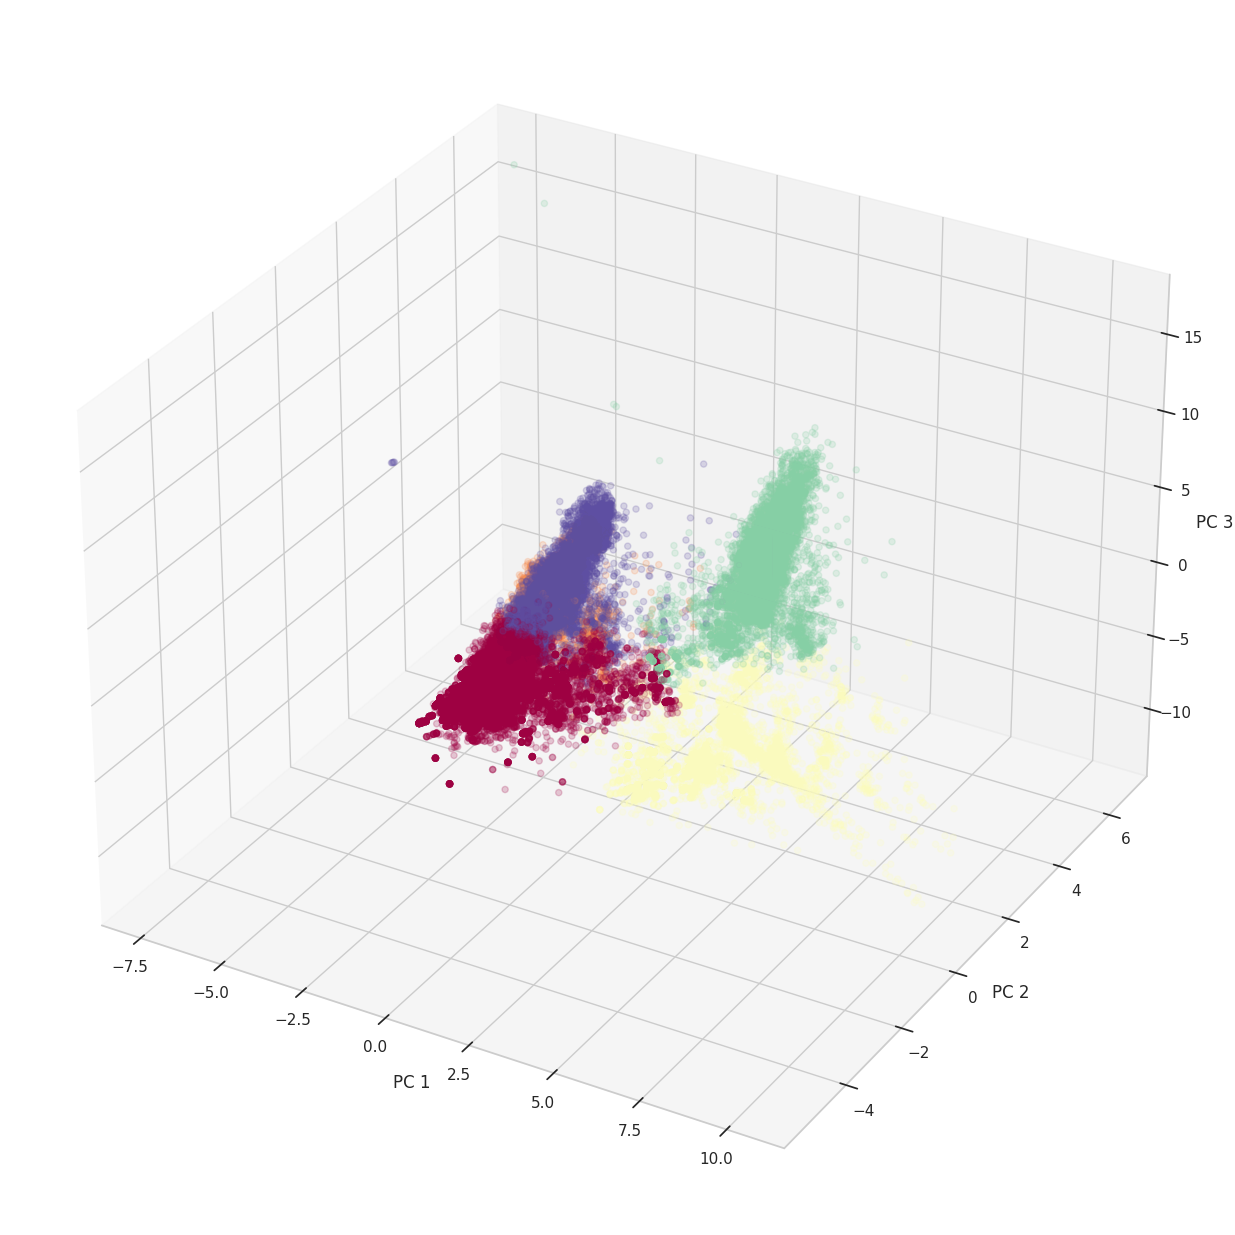

In [108]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection = '3d')

x = X_train_pca[:,0]
y = X_train_pca[:,1]
z = X_train_pca[:,2]

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

ax.scatter(x, y, z, c = labels, alpha = 0.2, cmap = 'Spectral')

plt.show()

Applying a pipeline containing the Scaler, PCA and KMeans clustering

In [109]:
scaler = StandardScaler()
pca_model = PCA_model = PCA(n_components = 4)
KMeans_model = KMeans(n_clusters = 5)

pipeline = make_pipeline(scaler, pca_model, KMeans_model)
pipeline.fit(X_train)
labels = pipeline.predict(X)
labels.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(119389,)

In [118]:
# assigning new labels to a new feature in dataset
hotels['cust_segmentation'] = labels.astype('str')

In [119]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119389 entries, 0 to 119388
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119389 non-null  object 
 1   is_canceled                     119389 non-null  int64  
 2   lead_time                       119389 non-null  int64  
 3   arrival_date_year               119389 non-null  int64  
 4   arrival_date_month              119389 non-null  int64  
 5   arrival_date_week_number        119389 non-null  int64  
 6   arrival_date_day_of_month       119389 non-null  int64  
 7   stays_in_weekend_nights         119389 non-null  int64  
 8   stays_in_week_nights            119389 non-null  int64  
 9   adults                          119389 non-null  int64  
 10  children                        119389 non-null  float64
 11  babies                          119389 non-null  int64  
 12  meal            

#### Visualizing customer segmentation

<Axes: xlabel='cust_segmentation', ylabel='adr'>

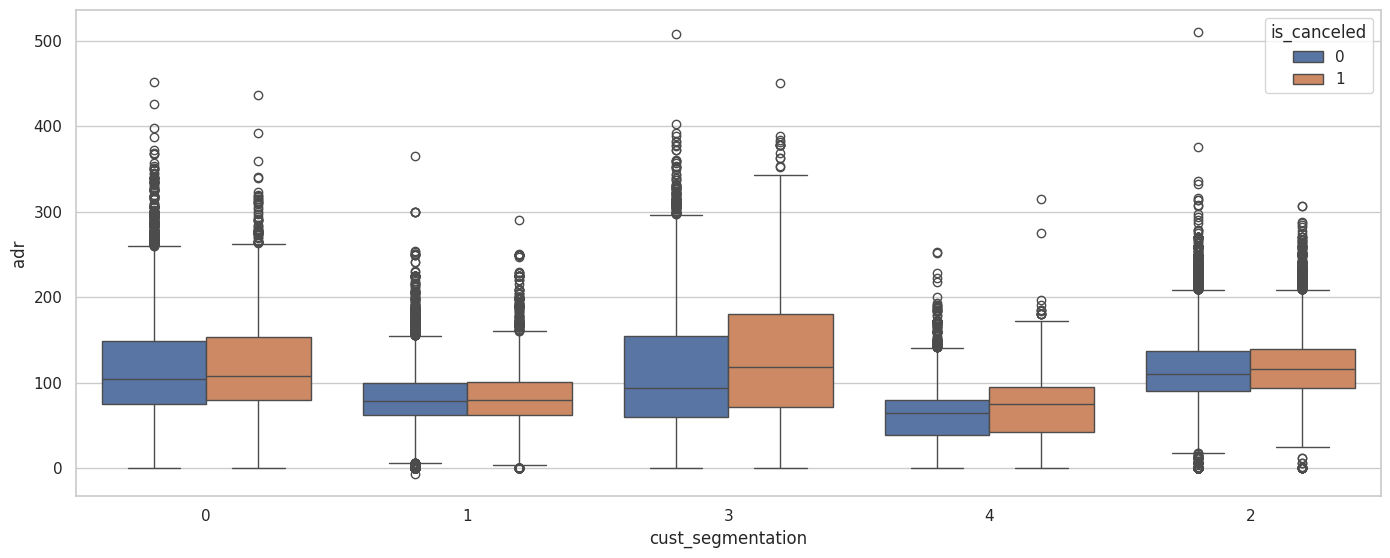

In [112]:
sns.boxplot(x = 'cust_segmentation', y = 'adr', hue = 'is_canceled', data = hotels)

<Axes: xlabel='cust_segmentation', ylabel='count'>

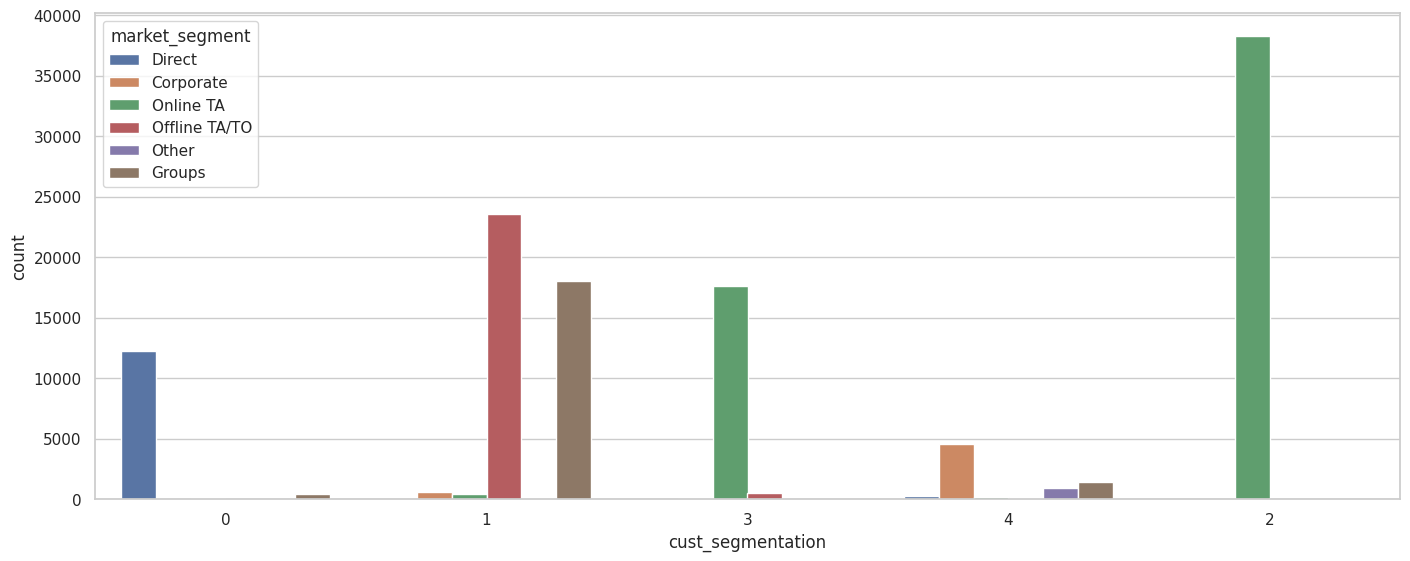

In [113]:
sns.countplot( data=hotels, hue="market_segment",x = "cust_segmentation")

<Axes: xlabel='cust_segmentation', ylabel='count'>

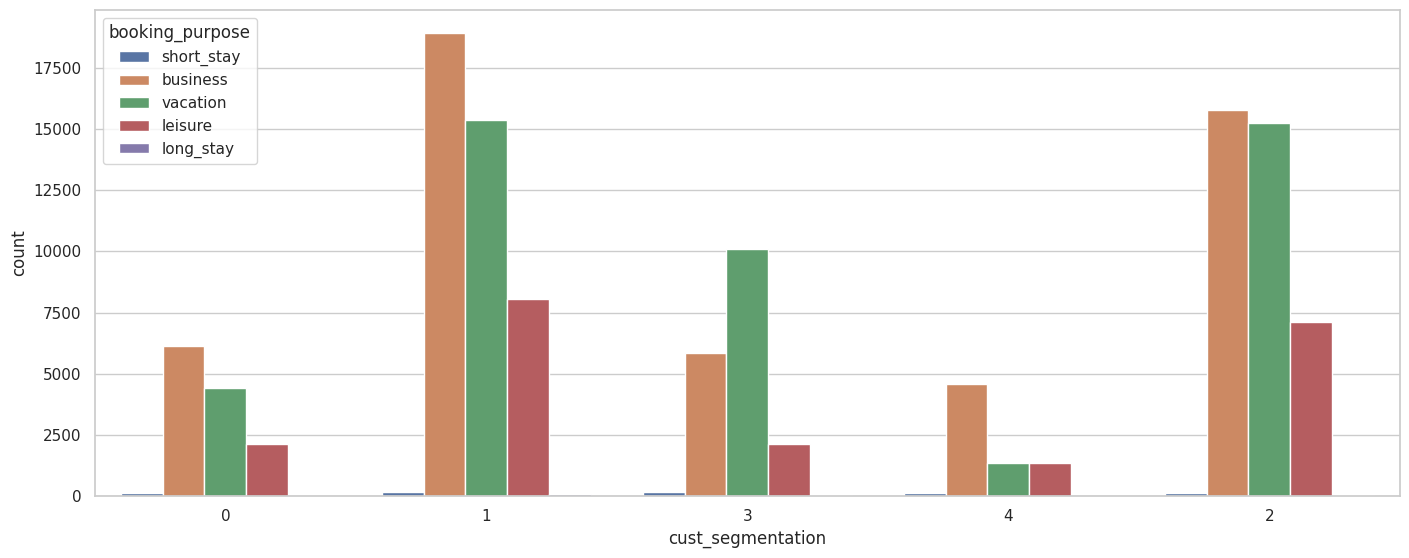

In [114]:
sns.countplot(hue = 'booking_purpose', x = 'cust_segmentation', data = hotels)

### **Saving data**

In [124]:
# saving model
best_clustering_model = pipeline
best_clustering_model.version = '1.0'
best_clustering_model.pandas_version = pd.__version__
best_clustering_model.numpy_version = np.__version__
best_clustering_model.sklearn_version = sklearn_version
best_clustering_model.X_columns = [col for col in X_train.columns]
best_clustering_model.build_datetime = datetime.datetime.now()

In [125]:
filename = "/content/drive/MyDrive/hotel-booking-cancellation-prediction/models/KMeans_clustering_pipeline.sav"
pickle.dump(best_clustering_model, open(filename, 'wb'))

In [126]:
hotels.to_csv(working_dir + "/interim/hotels_for_modeling.csv")